In [ ]:
"""
    Attempts for correlating factors of winning
    1. Understading playing style according a match outcome
    2. Finding correlation on current league"""

In [62]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [63]:
sns.set_style('darkgrid')

In [64]:
class Attr:
    def __init__(self, name, value, color=None):
        self.name = name
        self.value = value
        self.color = color

In [65]:
# This returns the correlation matrix, as well the features correlated over a given trheshold
def get_correlation(data, target, column_names, corr_method, target_name, thresh=0.5):
    df = pd.DataFrame(data, columns=column_names)
    df[target_name] = target
    X = df.drop(target_name,1)   #Feature Matrix
    y = df[target_name] 
    
    #Using Spearman Correlation
    corr = df.corr(method=corr_method)
    
    #Correlation with output variable biggest magnitude
    cor_target = abs(corr[target_name])
    #Selecting highly correlated features
    relevant_features = cor_target[cor_target>thresh]
    relevant_features = relevant_features.sort_values(ascending=False)
    
    return corr, relevant_features

# Use in the future
def heatmap_data(data, target, column_names, corr_method, target_name):
    #Using Spearman Correlation
    corr, _ = get_correlation(data, target, column_names, corr_method, target_name)
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap='mako', vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}).set_title("Features vs label")
    plt.show()

In [66]:
def get_value(attr):
    return attr.value

In [67]:
def sorted_class(names, values, color=None):
    attrs = []
    for i in range(0, len(names)):
        attrs.append(Attr(names[i], values[i]))
    attrs.sort(key=get_value)
    new_names = []
    new_values = []
    for i in range(0, len(names)):
        new_names.append(attrs[i].name)
        new_values.append(attrs[i].value)
    return new_names, new_values

In [68]:
# Set win as 1, draw as 0 and lose as -1
def get_status(r):
    goals_home = r["goals_home"]
    goals_away = r["goals_away"]
    if goals_home > goals_away:
        return 1
    elif goals_home == goals_away:
        return 0
    else:
        return -1

In [69]:
def get_target(df):
    # status_home: either win, draw or lose for home team, predicted label
    target = []
    for index, row in df.iterrows():
        target.append(get_status(row))
    return target

In [70]:
def pass_nan(pass_percentage):
    if pass_percentage == "0.0":
        return "50%"
    else:
        return pass_percentage

In [71]:
def clean_data(df):
    df = df.drop(df.columns[0], axis=1)
    df = df.drop(columns=["league","id"], axis=1)
    df["home_team.id"] = df["team_home.team.id"]
    df["away_team.id"] = df["team_away.team.id"]
    df["home_team.name"] = df["team_home.team.name"]
    df["away_team.name"] = df["team_away.team.name"]
    # Just fixtures statistics
    df = df.drop(df.filter(regex='team_away').columns, axis=1)
    df = df.drop(df.filter(regex='team_home.').columns, axis=1)
    df["stats_away.p_percentage"] = df["stats_away.p_accurate"]/df["stats_away.p_total"]
    df["stats_home.p_percentage"] = df["stats_home.p_accurate"]/df["stats_home.p_total"]
    # None values set to 0
    df.fillna(value=0, inplace=True)
    # Posession % to decimal
    df["stats_away.possession"] = df["stats_away.possession"].apply(lambda x: (int(str(x).strip('%'))/100))
    df["stats_home.possession"] = df["stats_home.possession"].apply(lambda x: (int(str(x).strip('%'))/100))
    return df

In [72]:
def df_season(country, league, season, week, drop_goals=True):
    dirCountry = '../' + country + '/'
    dirName = dirCountry + league + '/' + str(season) + '/'
    file_title = str(season) + '_' + str(week) + '.csv'
    csv_file = dirName + file_title
    df = pd.read_csv(csv_file)
    df = clean_data(df)
    target = get_target(df)
    if drop_goals:
        df = df.drop(columns=["goals_away","goals_home"], axis=1) 
    return df, target

In [73]:
def group_targets(target):
    wins_home = 0
    draws = 0
    loses_home = 0
    for label in target:
        if label == 1:
            wins_home = wins_home + 1
        elif label == 0:
            draws = draws + 1
        elif label == -1:
            loses_home = loses_home + 1
    x = ['wins_home', 'draws', 'loses_home']
    y = [wins_home, draws, loses_home]
    return x, y

In [74]:
def bar_graph(axs, row, column, y, x_label, y_label):
    axs[row, column].bar(x_label, y, color='darkslateblue')
    axs[row, column].set_title(y_label)
    for i in range(len(x_label)):
        axs[row, column].annotate(str(y[i]), xy=(x_label[i], y[i]))
    return axs

In [75]:
def weights_graph(axs, row, season, model, val, rmse, r_sq, weights, x_label):
    title = str(season) + ' ' + model + ' ' + val
    rmse_txt = "RMSE: " + '{0:.2f}'.format(rmse)
    r_txt = "R^2: " + '{0:.2f}'.format(r_sq)
    x_label, weights = sorted_class(x_label, weights)
    axs[row].bar(x_label, weights, color="darkslateblue")
    axs[row].set_title(title)
    axs[row].text(1, 1.1, rmse_txt, color="midnightblue", fontsize=10, horizontalalignment='center', verticalalignment='center',
     transform = axs[row].transAxes)
    axs[row].text(1, 1.2, r_txt, color="midnightblue", fontsize=10, horizontalalignment='center', verticalalignment='center',
     transform = axs[row].transAxes)
    axs[row].tick_params(axis='x', labelrotation=90)
    for i in range(len(x_label)):
        axs[row].annotate('{0:.2f}'.format(weights[i]), xy=(x_label[i], weights[i]), verticalalignment='bottom')
    return axs

In [125]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

def ols_ridge(season, data, target, test_len=None, cross_val=None):
    r = 2
    fig, axs = plt.subplots(r)
    fig.set_size_inches(18.5, 10.5)
    # Create index mat
    mat = [j for j in range(0, r)]
    i = 0
    Y = None
    X_test = None
    
    try:
        data = data.drop(columns=['week','home_team.id', 'away_team.id','home_team.name', 'away_team.name'])
    except:
        print('Other')
    
    x_label = data.columns
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    if test_len != None:
        X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=test_len, random_state=0)
    classifiers = dict(ols=linear_model.LinearRegression(), ridge=linear_model.Ridge(alpha=.1))
    
    for name, clf in classifiers.items():
        if cross_val != None:
            clf_mse = cross_validate(clf, data, target, cv=cross_val, scoring=('r2', 'neg_mean_squared_error'), return_train_score=True, return_estimator=True)
            mse_sqr = np.sqrt(clf_mse['test_neg_mean_squared_error'].mean()*-1)
            mse_r = np.sqrt(clf_mse['test_r2'].mean())
            coef = []
            for model in clf_mse['estimator']:
                coef.append(model.coef_)
            final_coef = np.matrix(coef)
            final_coef = final_coef.mean(0)
            final_coef = np.array(final_coef).flatten()
            axs = weights_graph(axs, mat[i], season, name, "cv-5", mse_sqr, mse_r, final_coef, x_label)
        else:
            clf.fit(X_train, y_train)
            Y = clf.predict(X_test)
            mse = mean_squared_error(y_test, Y)
            axs = weights_graph(axs, mat[i], season, name, "train-test", np.sqrt(mse), clf.score(X_test, y_test), clf.coef_, x_label)
        i = i + 1
    
    fig.tight_layout()
    plt.show()

In [77]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import Pipeline

def svm_kernel(season, data, target, cross_val=5):
    scaler = StandardScaler()
    svc = svm.SVC()
    svc_kernel = ['linear', 'rbf', 'poly']

    param_grid = {
        'svc__kernel': svc_kernel
    }
    
    # Just the best estimator
    r = 3
    fig, axs = plt.subplots(r)
    fig.set_size_inches(18.5, 13.5)
    # Create index mat
    mat = [j for j in range(0, r)]
    
    try:
        data = data.drop(columns=['week','home_team.id', 'away_team.id','home_team.name', 'away_team.name'])
    except:
        print("Other type")
    x_label = data.columns
    
    pipe = Pipeline([('scaler', scaler), ('svc', svc)])
    grid = GridSearchCV(pipe, param_grid, cv=cross_val, refit=True)
    grid.fit(data, target)
    y_pred = cross_val_predict(grid, data, target, cv=cross_val)
    print("Confusion Matrix:\n", confusion_matrix(target, y_pred))
    print("Classification Report:\n", classification_report(target, y_pred))
    # Best kernel classifier
    name = grid.best_params_['svc__kernel']
    # Best weights coef
    sv = svm.SVC(kernel=name)
    sv = sv.fit(data, target)
    coef = sv.coef_

    mse_sqr = np.sqrt(mean_squared_error(target, y_pred))
    mse_r = np.sqrt(r2_score(target, y_pred))
    
    i = 0
    for c in coef:
        if i == 0:
            graph_name = name + " lose"
        if i == 1:
            graph_name = name + " draw"
        if i == 2:
            graph_name = name + " win"
        axs = weights_graph(axs, mat[i], season, graph_name, "cv-5",  mse_sqr, mse_r, c, x_label)
        i = i + 1
    
    
    fig.tight_layout()
    plt.show()

In [78]:
def mod_target(target):
    new_target = []
    for label in target:
        if label != 1:
            new_target.append(0)
        else:
            new_target.append(1)
    return new_target

In [79]:
def draw_vs_loss(data, target):
    new_data =[]
    new_target = []
    i = 0
    for index, row in data.iterrows():
        current_target = target[i]
        i = i + 1
        if current_target == 1:
            continue
        elif current_target == 0:
            current_target = 1
        elif current_target == -1:
            current_target = 0
        new_data.append(row.values)
        new_target.append(current_target)
    df_new = pd.DataFrame(new_data, columns=data.columns)
    return df_new, new_target

In [80]:
def get_all(data):
    all_data = pd.DataFrame()
    all_target = []
    for d in data:
        all_data = all_data.append(d[1])
        all_target = all_target + d[2]
    return all_data, all_target

In [146]:
def get_diff(data):
    diff_goals = np.array([])
    for d in data:
        diff_goals = np.append(diff_goals, (d[1]["goals_home"] - d[1]["goals_away"]))
    return diff_goals

In [155]:
# League directory
country = 'ES'
league = '140'
curr_week = 38

In [156]:
# Historicity: multi season directory
year_window = 4
start_season = 2019
seasons = list(range(start_season, start_season - year_window, -1))
print(seasons)

[2019, 2018, 2017, 2016]


In [157]:
# Data initialization
data = []
for season in seasons:
    df, target = df_season(country, league, season, curr_week)
    tup = (season, df, target)
    data.append(tup)

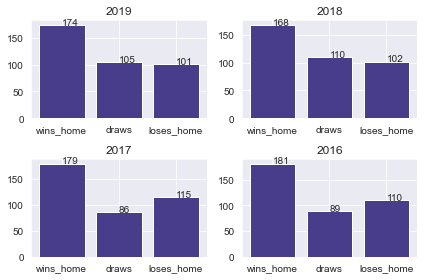

In [158]:
# Labels balance
r = 2
c = 2
fig, axs = plt.subplots(r, c)
# Create index mat
mat = [[i,j] for i in range(0, r) for j in range(0, c)]
i = 0
for d in data:
    # d[2] is the target
    x, y = group_targets(d[2])
    axs = bar_graph(axs, mat[i][0], mat[i][1], y, x, d[0])
    i = i + 1
fig.tight_layout()
plt.show()

In [85]:
"""
    Feature relevance between wins, draws and loses
"""

'\n    Feature relevance between wins, draws and loses\n'

In [160]:
# Data initialization
data_diff = []
for season in seasons:
    df, target = df_season(country, league, season, curr_week, drop_goals=False)
    tup = (season, df, target)
    data_diff.append(tup)
diff_target = get_diff(data_diff)

In [161]:
print(diff_target)

[ 2.  3.  2. ... -3. -1. -1.]


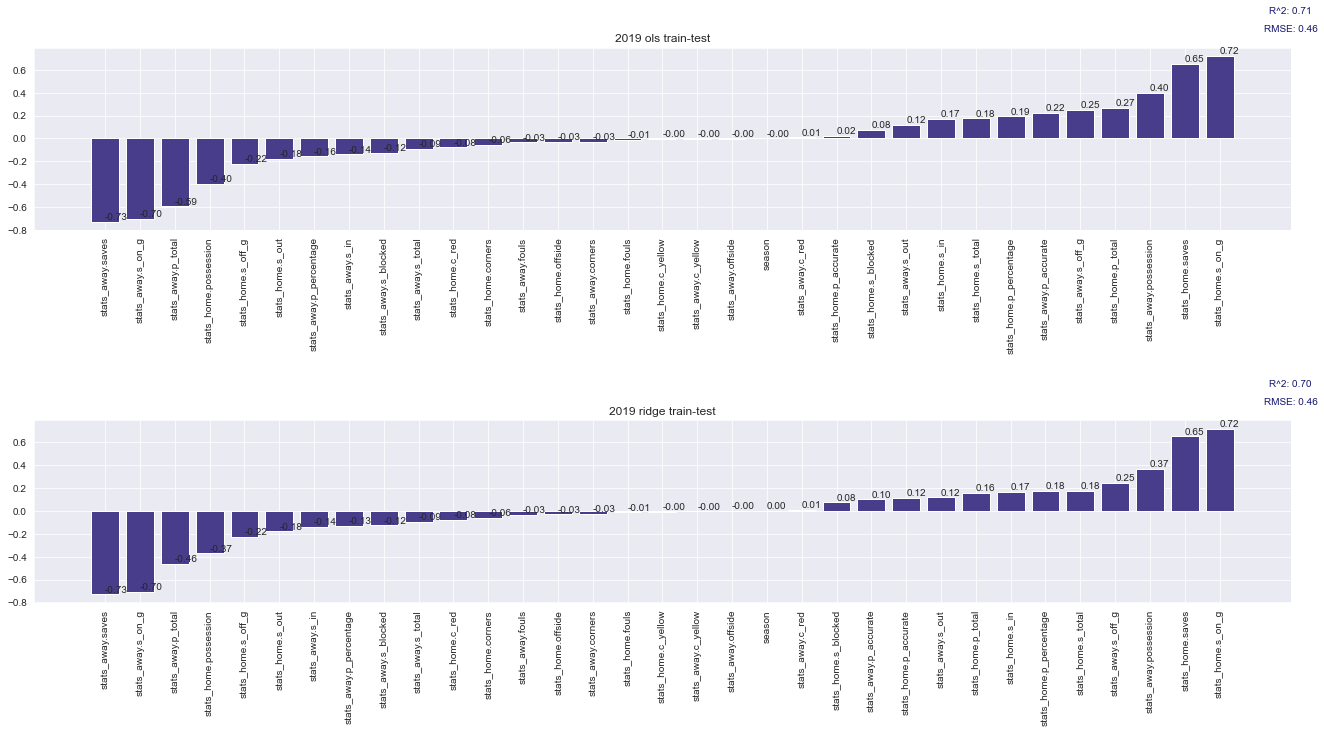

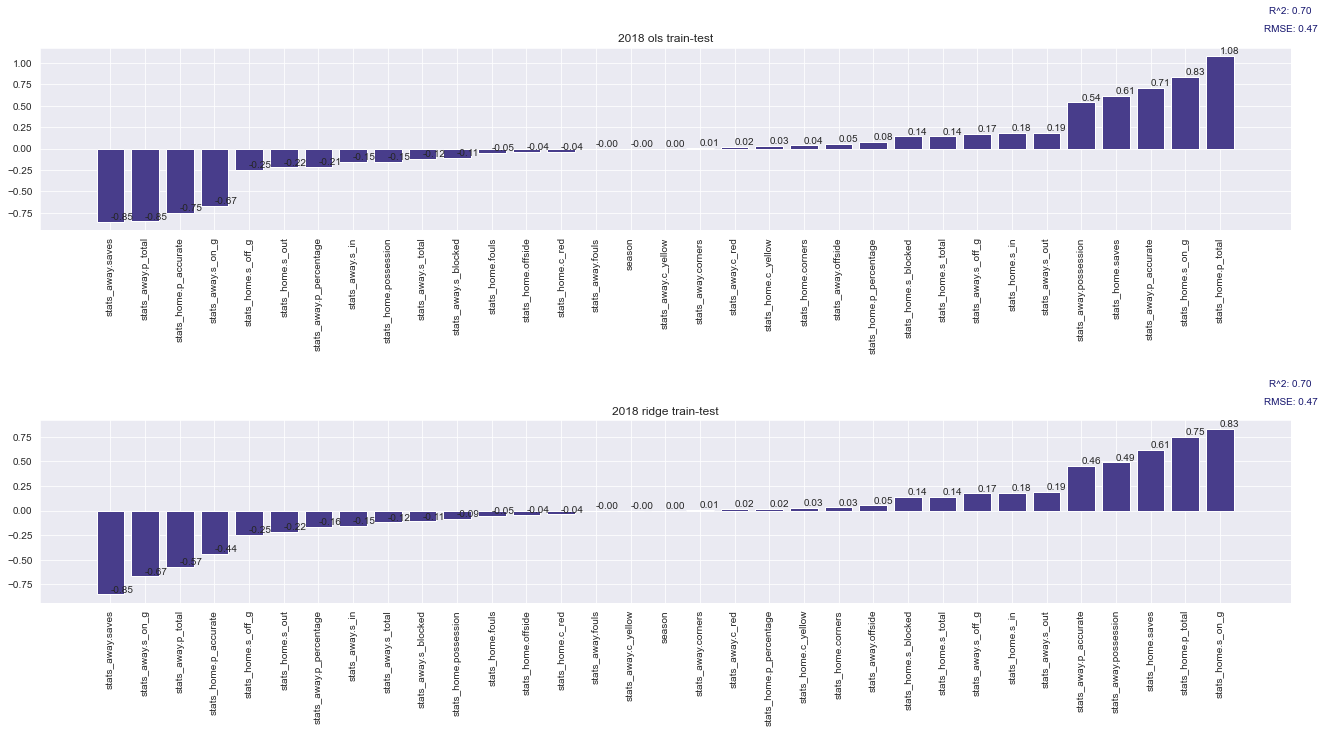

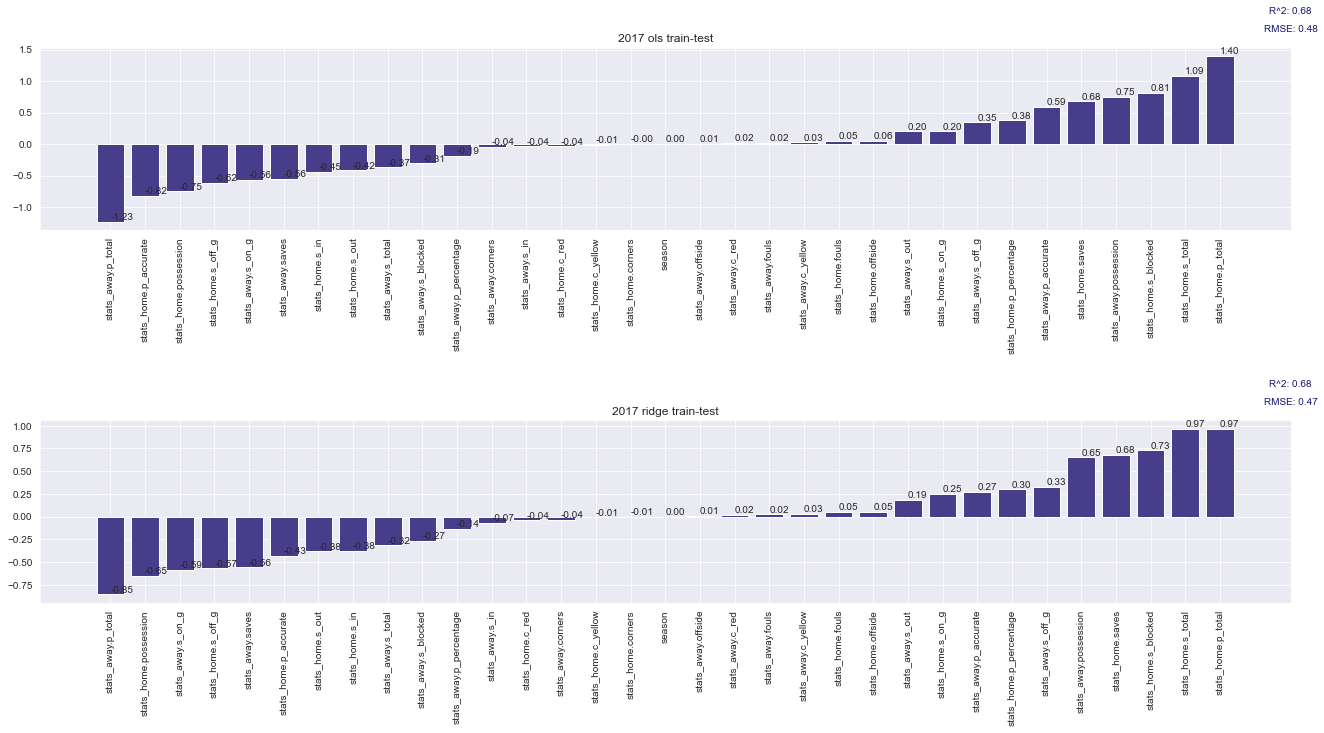

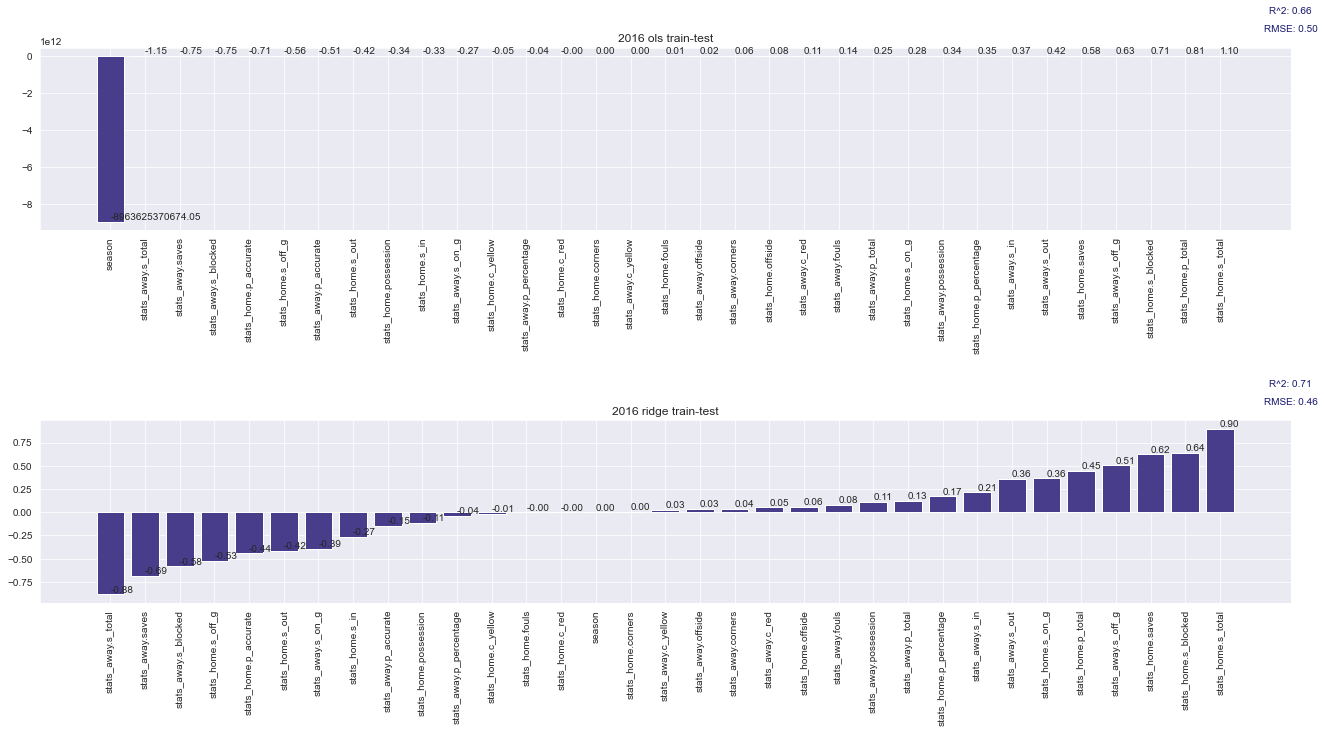

In [162]:
for d in data:
    ols_ridge(d[0], d[1], d[2], test_len = 0.2)

In [163]:
"""
    Here we have a dataset with the 4 years together
"""
all_data, all_target = get_all(data)

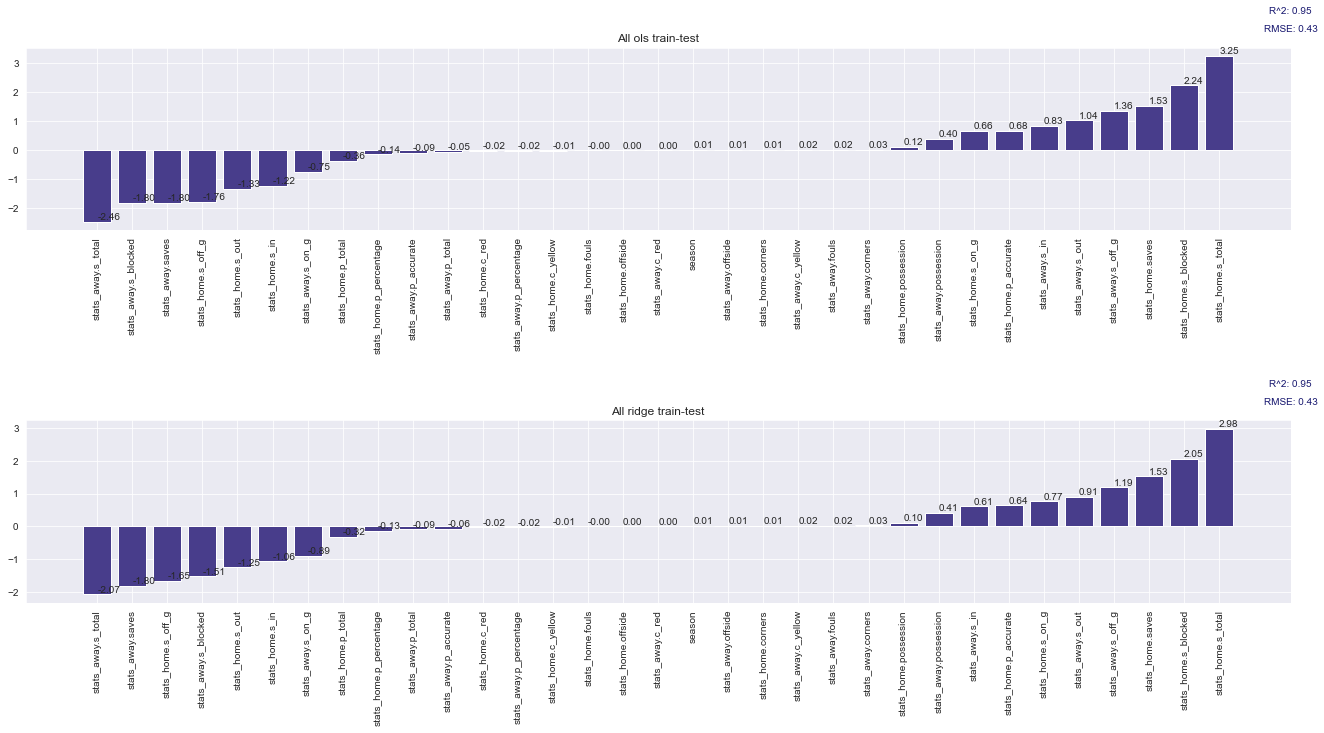

In [164]:
# All data
ols_ridge("All", all_data, diff_target, test_len = 0.2)

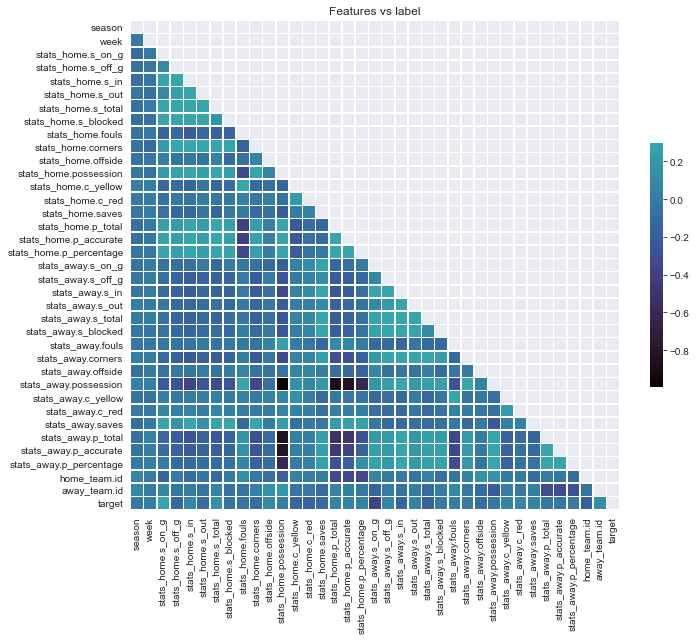

In [89]:
heatmap_data(all_data, all_target, all_data.columns, 'spearman', 'target')

In [90]:
_, relevant_features = get_correlation(all_data, all_target, all_data.columns, 'spearman', 'target', thresh=0.1)
print(relevant_features)

target                 1.000000
stats_away.s_on_g      0.378619
stats_home.s_on_g      0.371747
home_team.id           0.192786
stats_away.s_total     0.177125
stats_home.c_red       0.161119
stats_home.s_total     0.160251
stats_away.s_in        0.139822
stats_home.c_yellow    0.136101
away_team.id           0.134088
stats_home.offside     0.109504
stats_home.s_off_g     0.106111
Name: target, dtype: float64


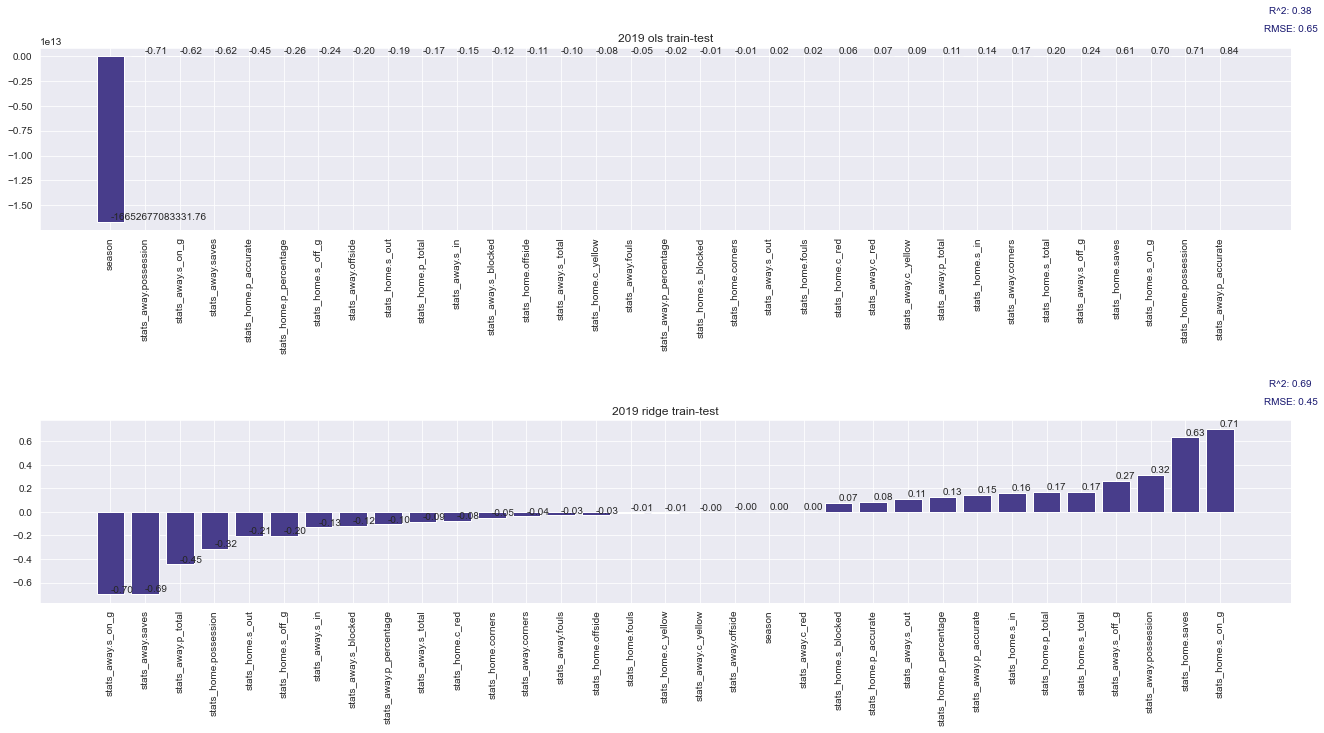

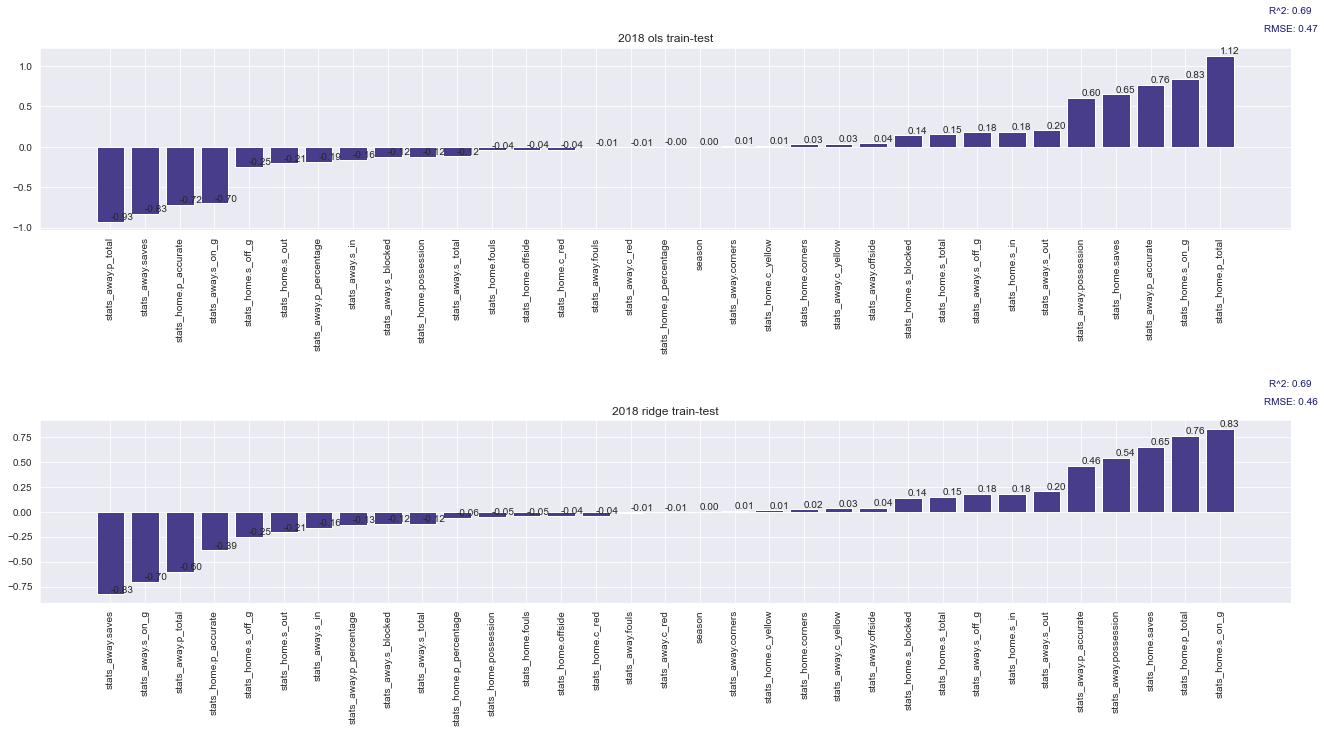

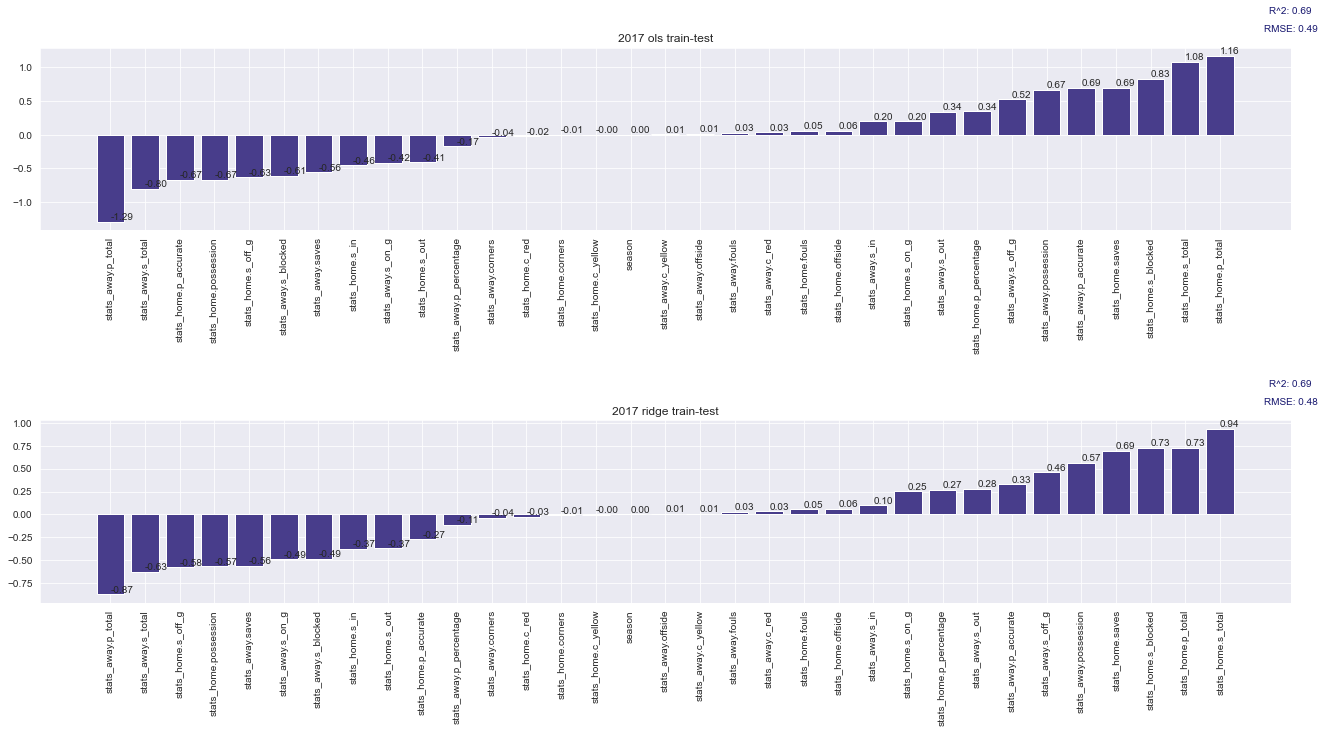

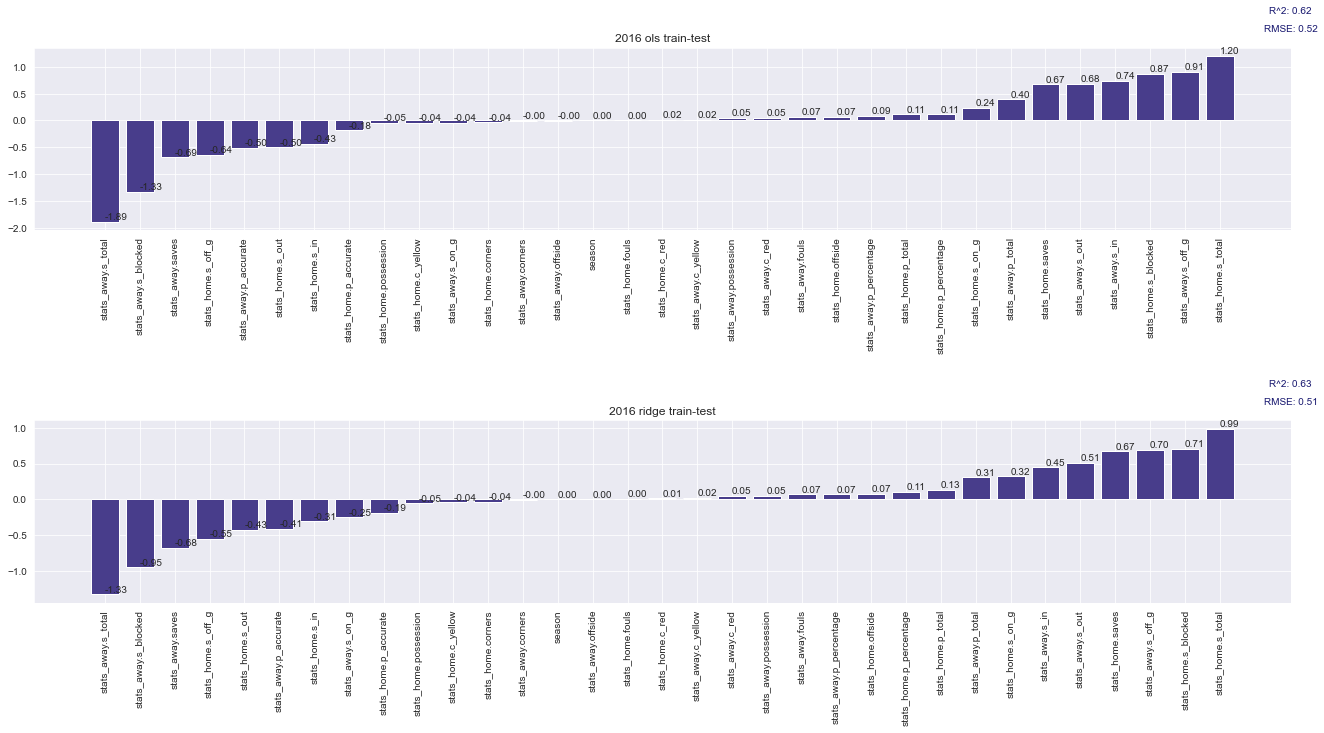

In [91]:
# OLS vs ridge from 2019 to 2016
# Training 70/30
for d in data:
    ols_ridge(d[0], d[1], d[2], test_len = 0.3)

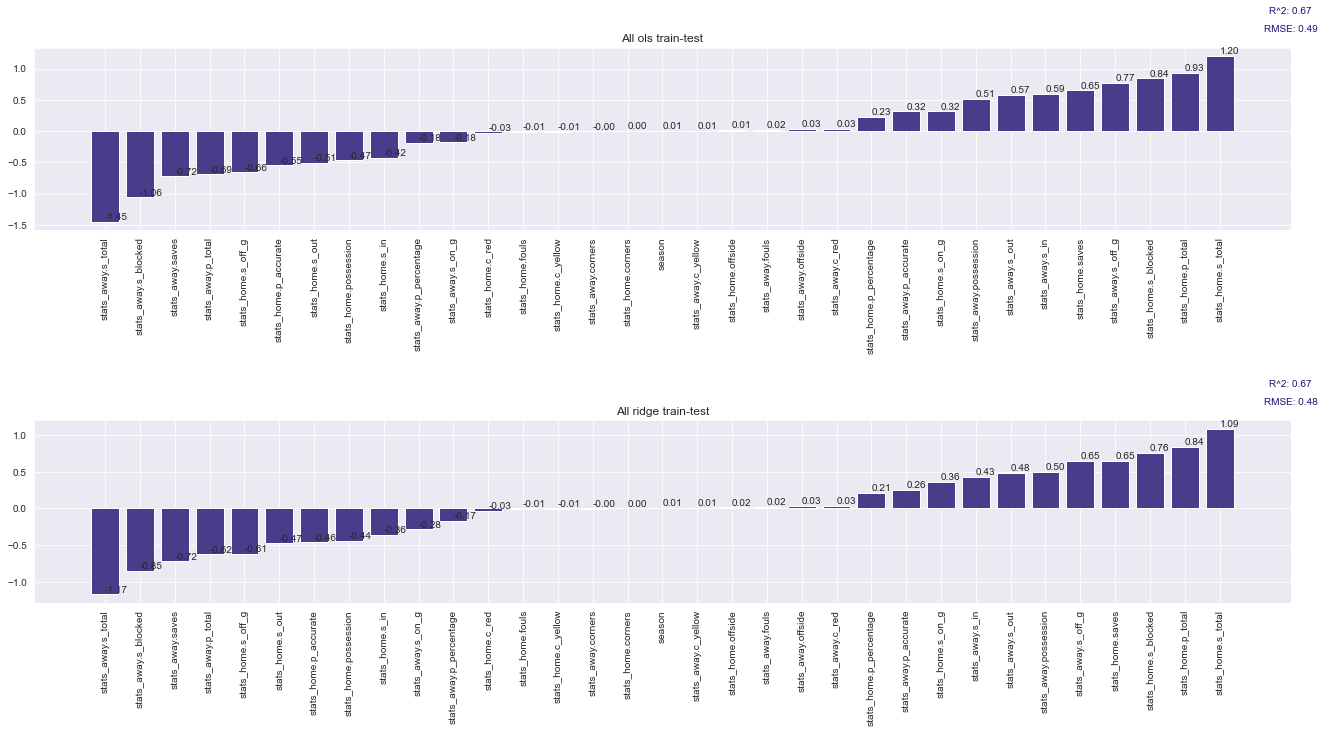

In [92]:
# All data
all_data, all_target = get_all(data)
ols_ridge("All", all_data, all_target, test_len = 0.3)

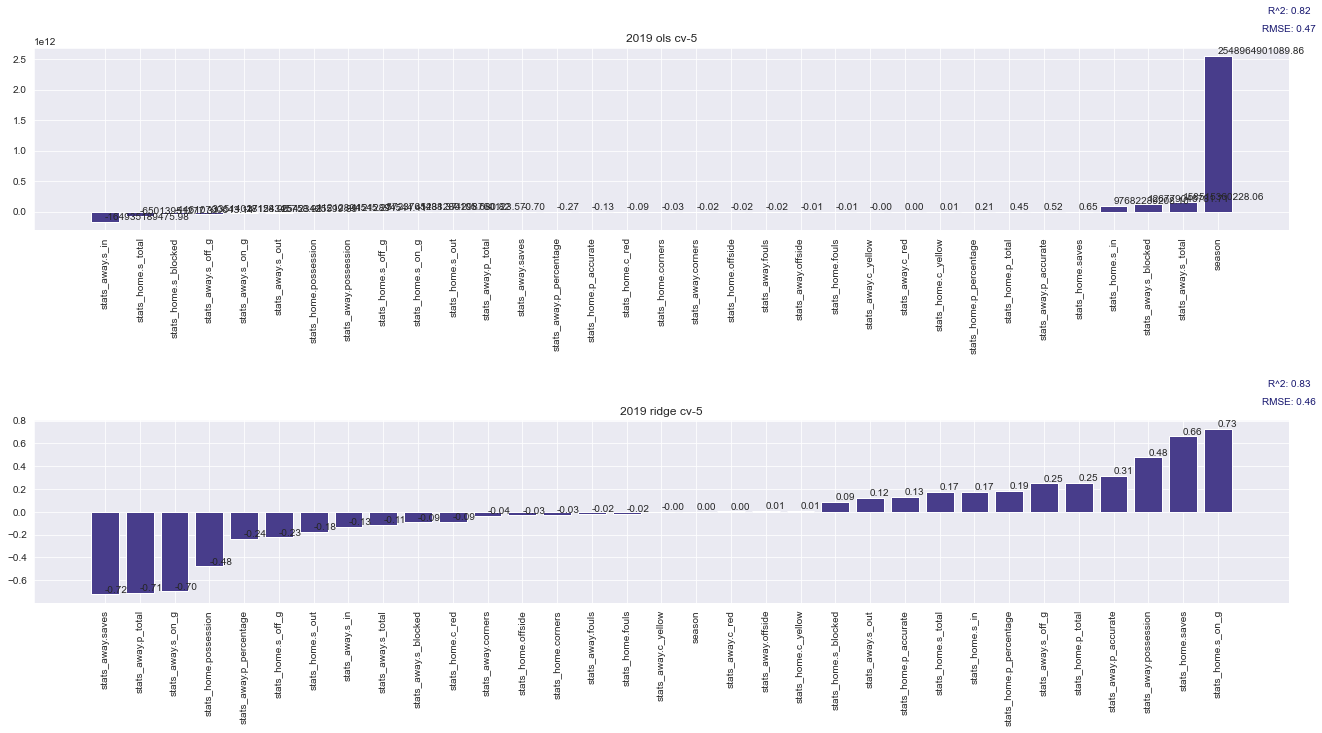

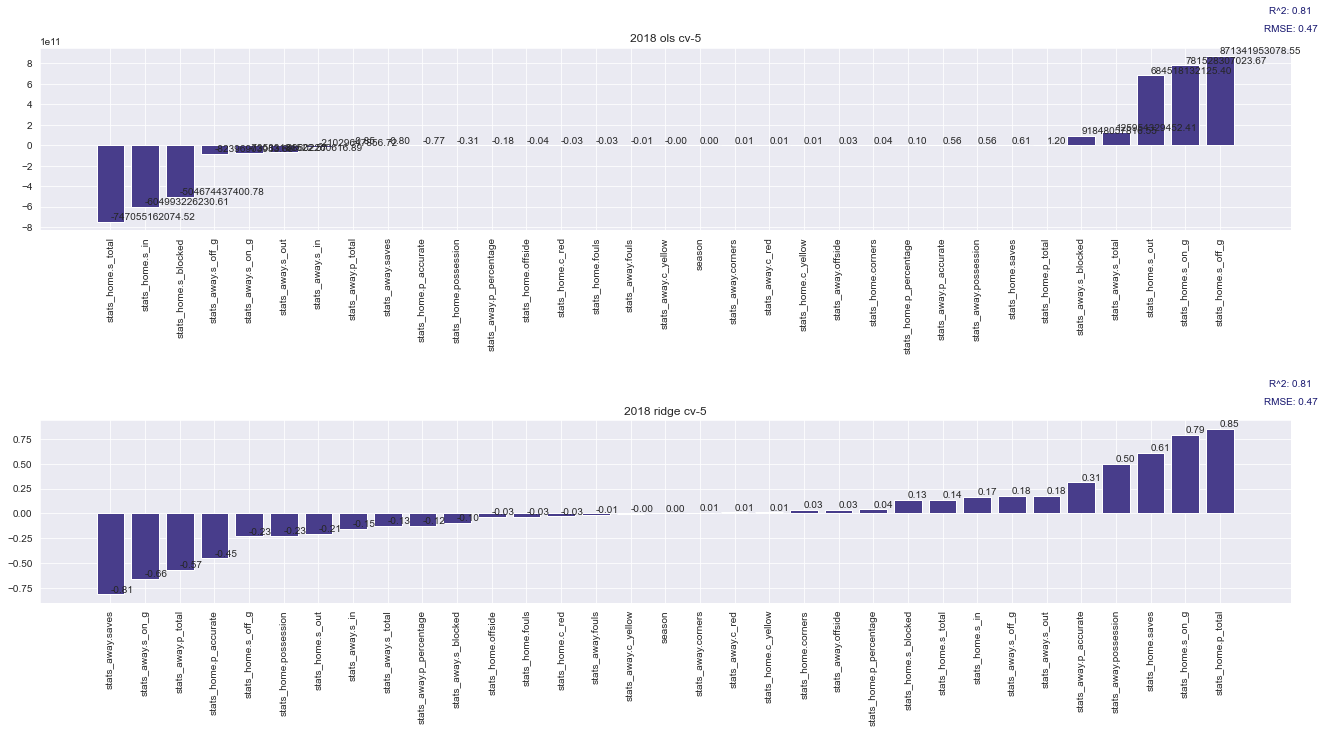

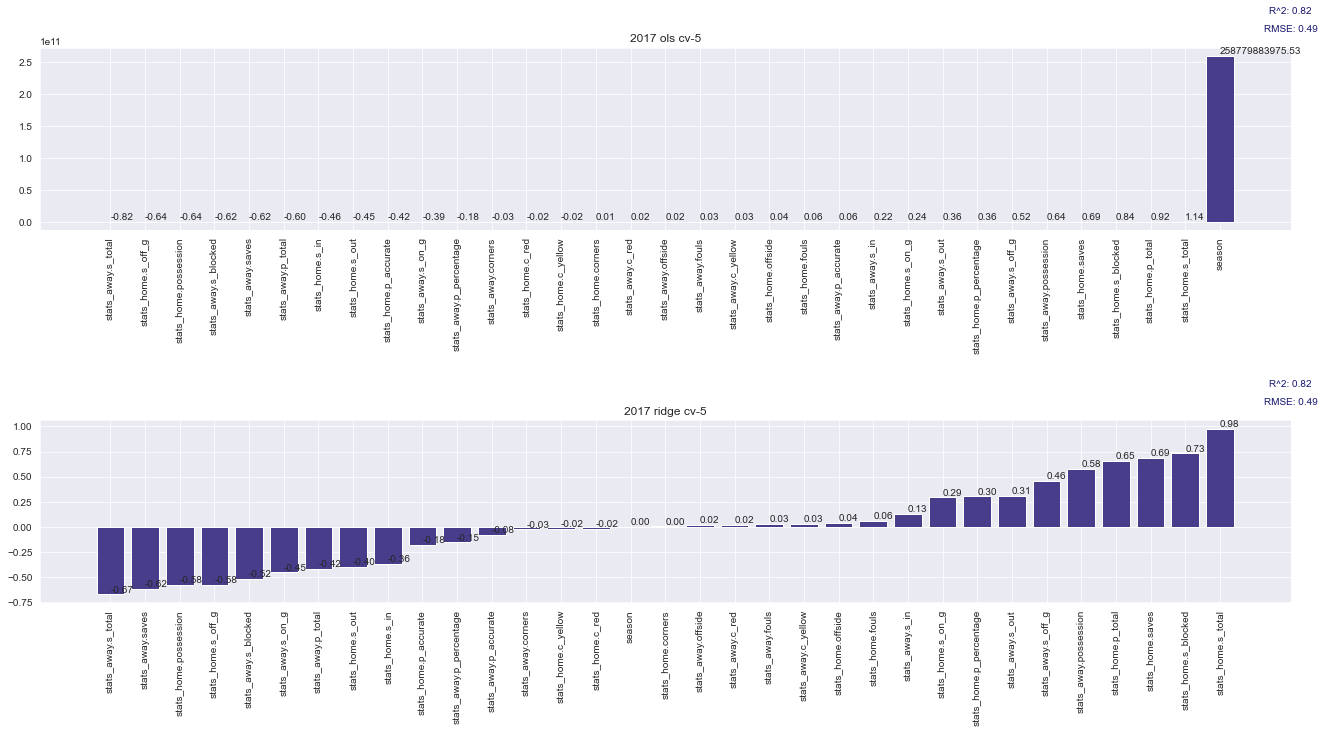

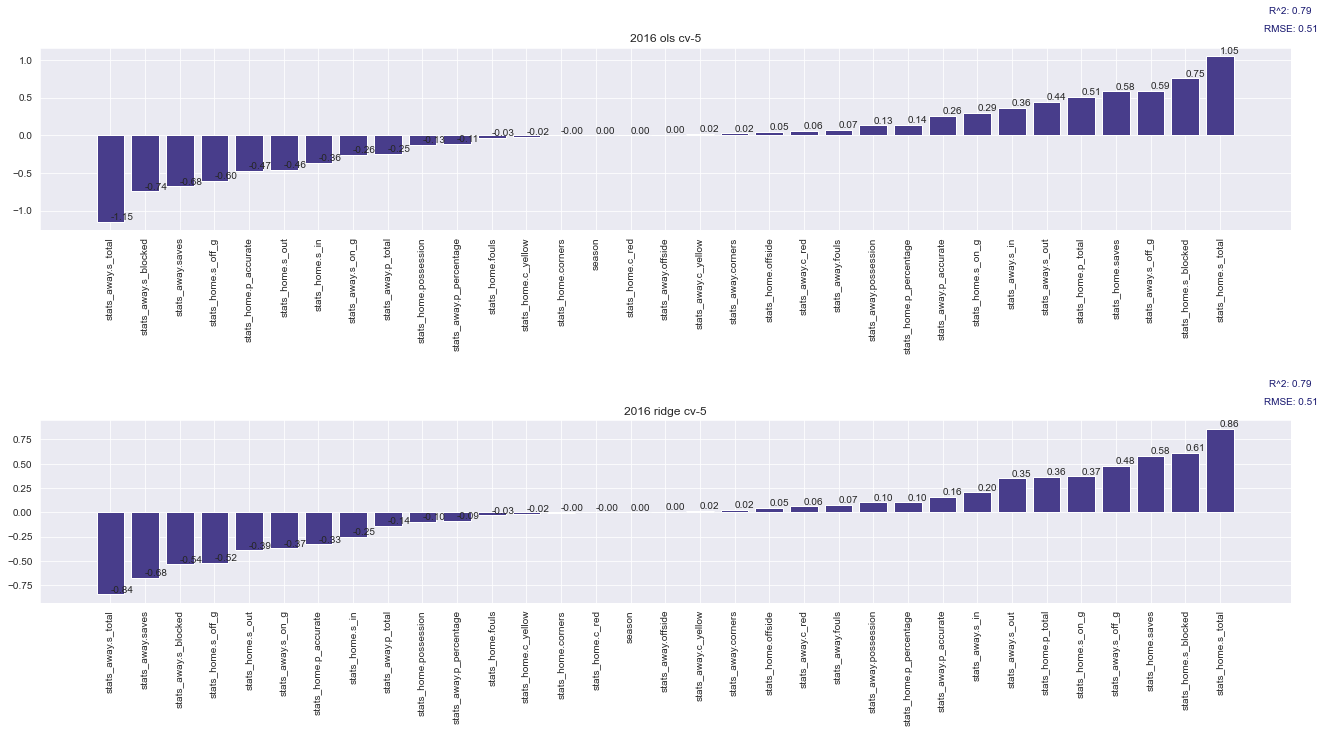

In [93]:
# OLS vs ridge from 2019 to 2016
# CV
for d in data:
    ols_ridge(d[0], d[1], d[2], cross_val=5)

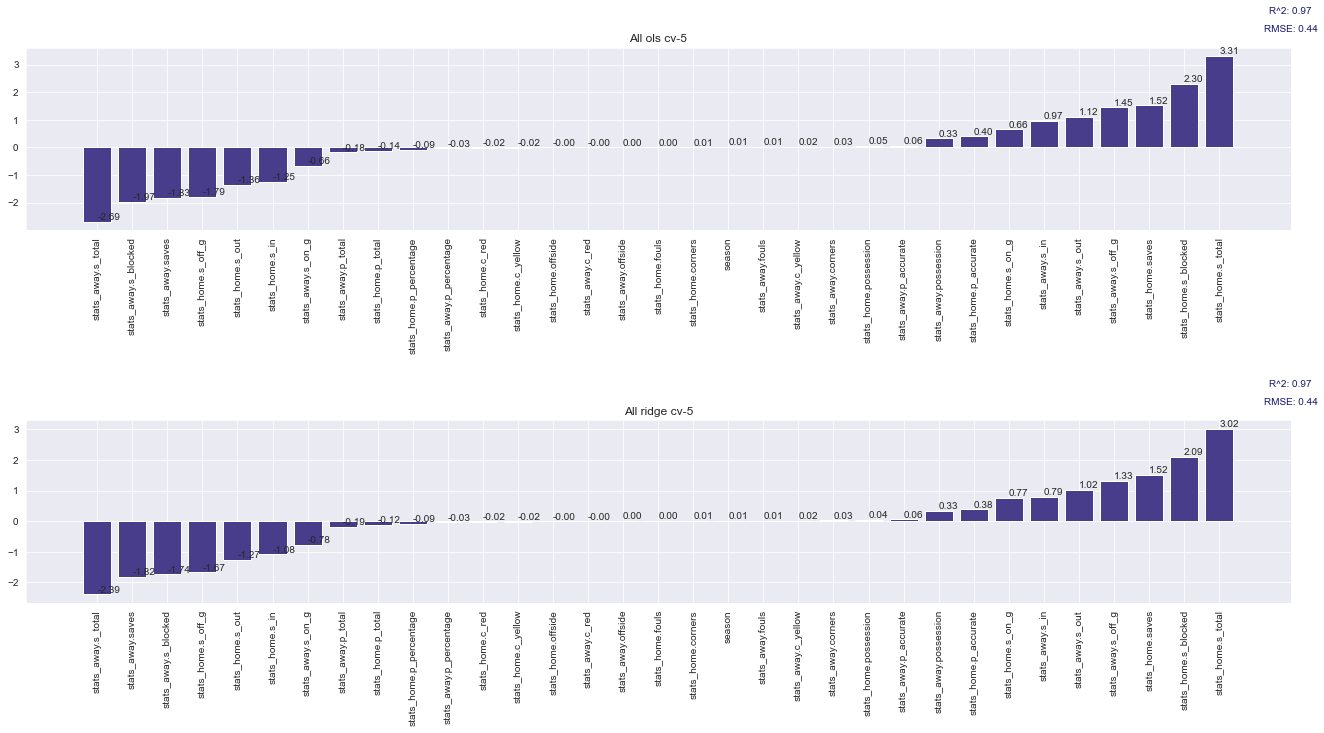

In [165]:
# All data
all_data, all_target = get_all(data)
ols_ridge("All", all_data, diff_target, cross_val=5)

In [95]:
"""
    Feature relevance between what is a win and not a win (either draw or loss)
"""

'\n    Feature relevance between what is a win and not a win (either draw or loss)\n'

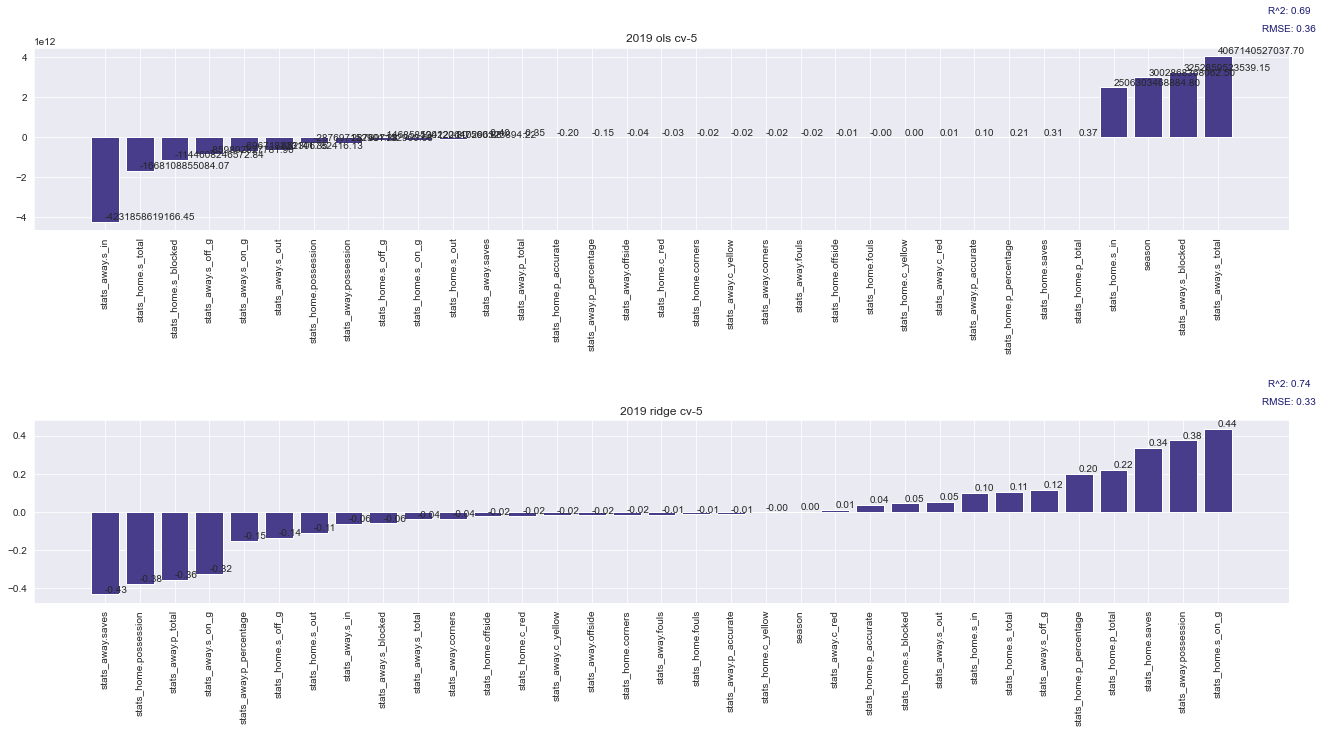

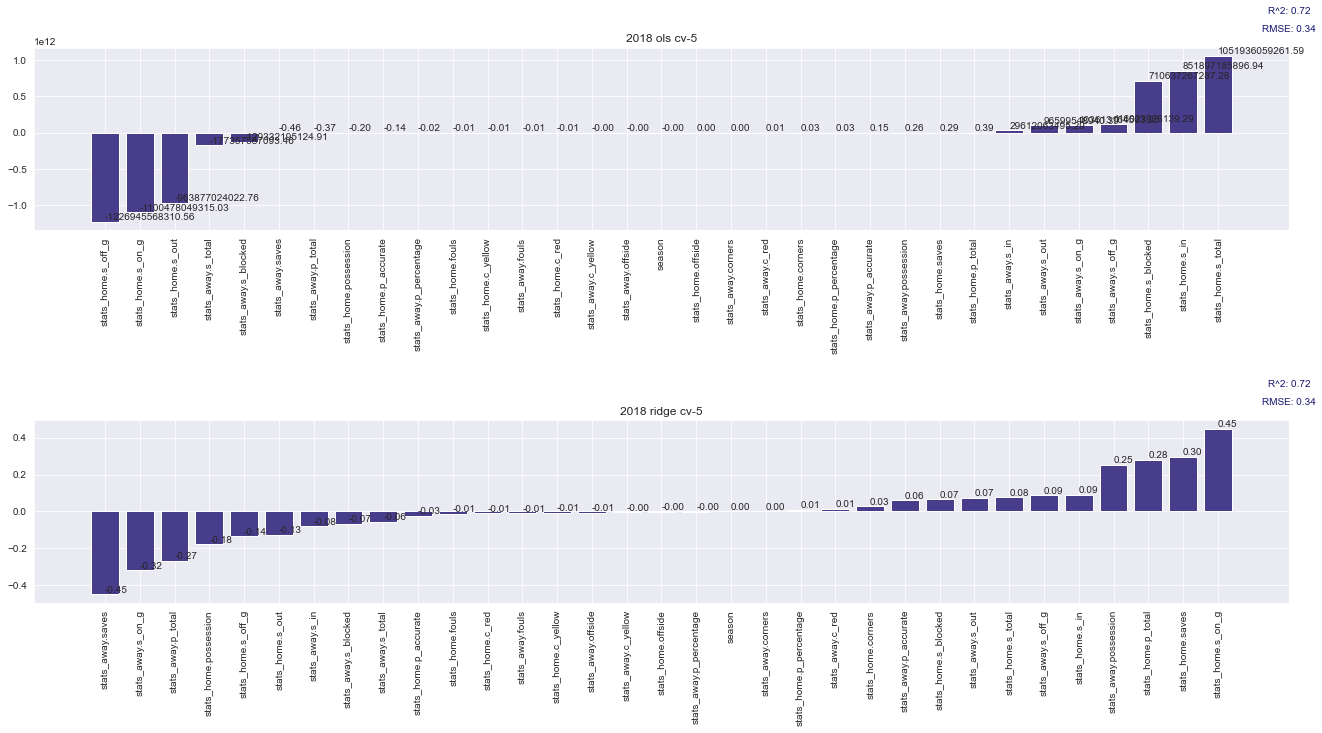

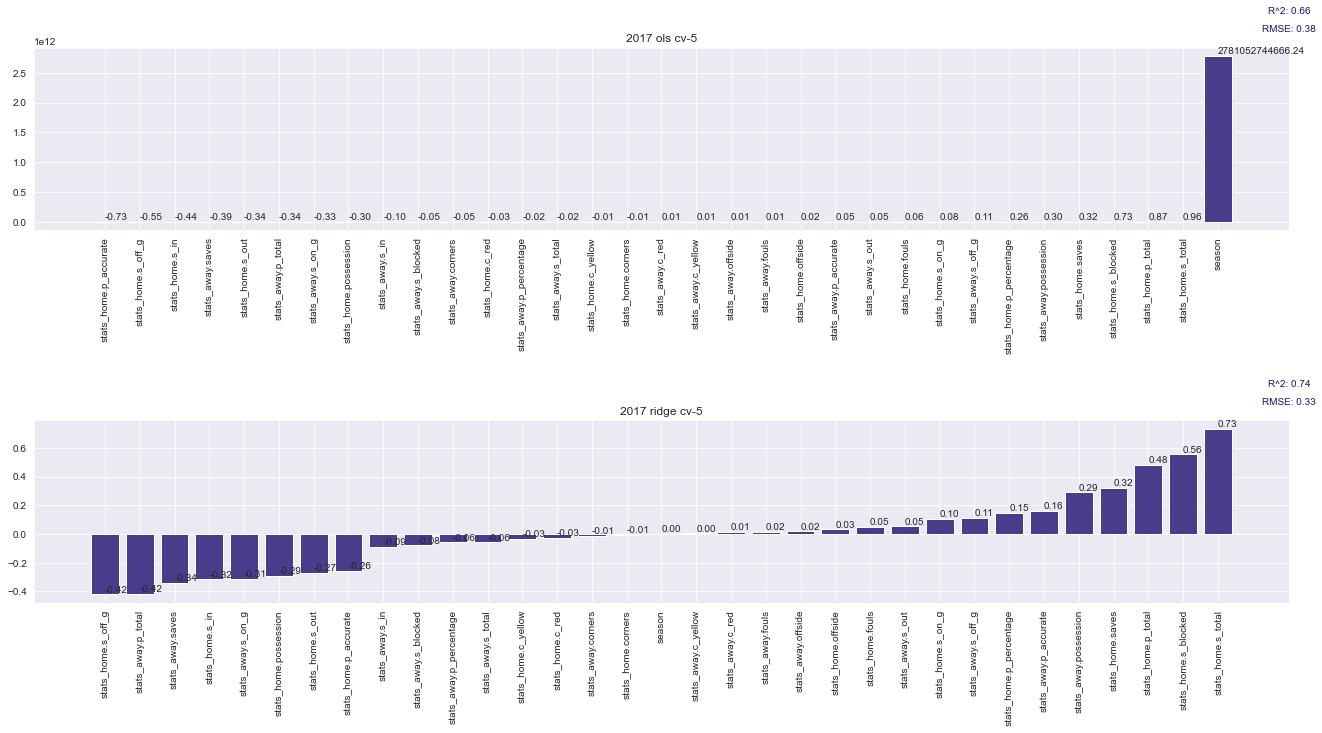

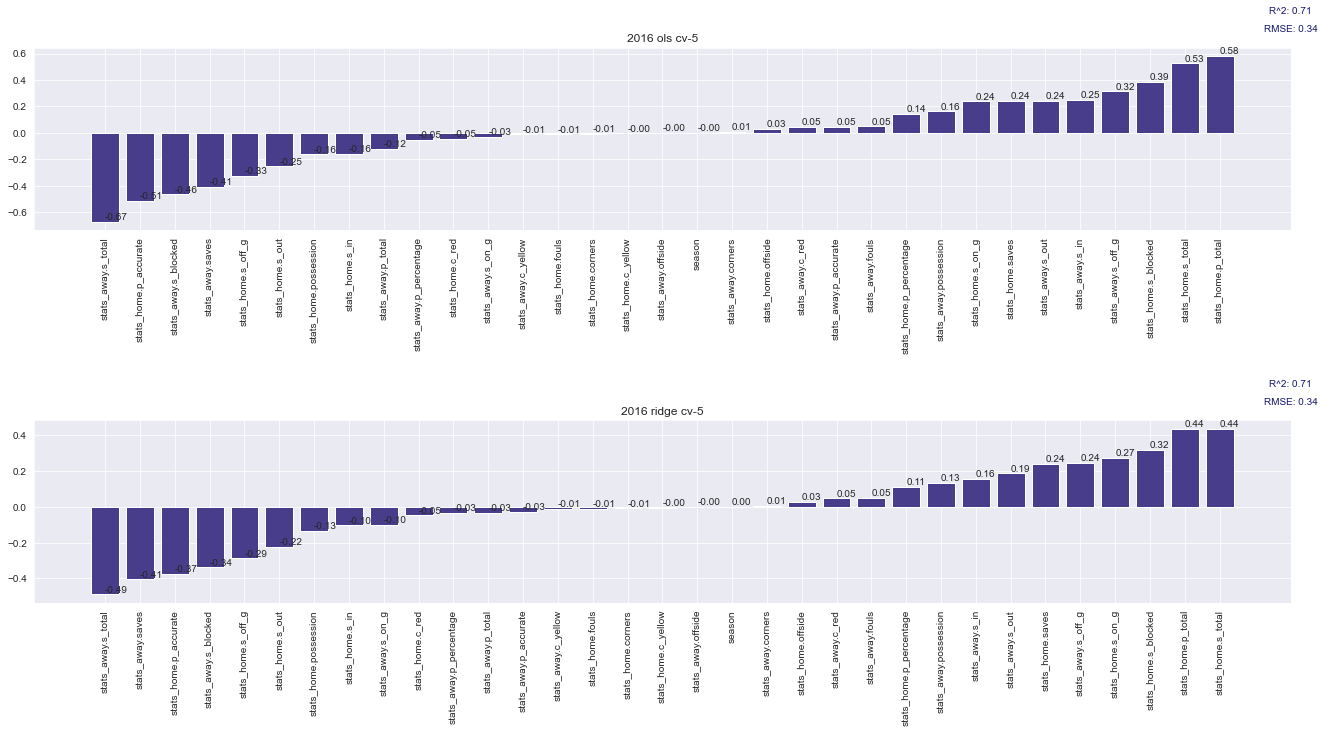

In [96]:
# Labels as 1 for home_win, 0 else
for d in data:
    new_target = mod_target(d[2])
    ols_ridge(d[0], d[1], new_target, cross_val = 5)

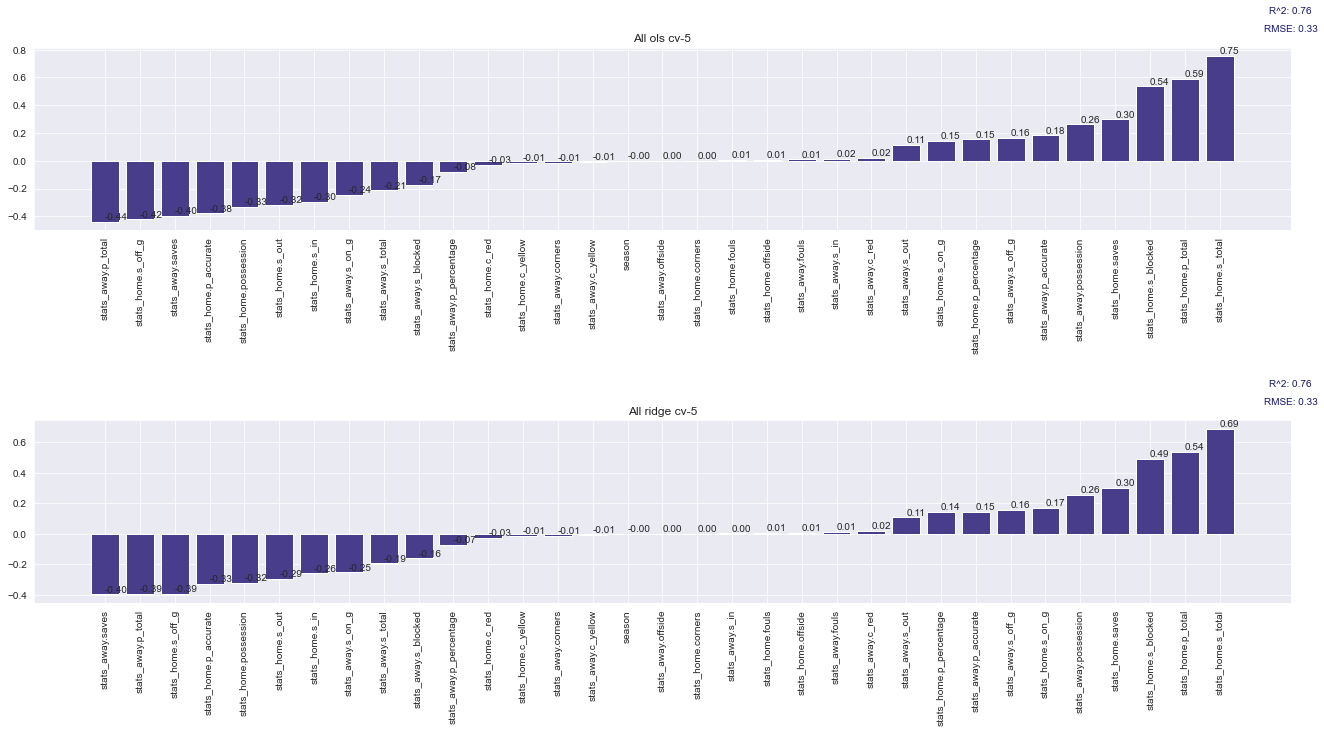

In [97]:
# All data
all_data, all_target = get_all(data)
new_target = mod_target(all_target)
ols_ridge("All", all_data, new_target, cross_val = 5)

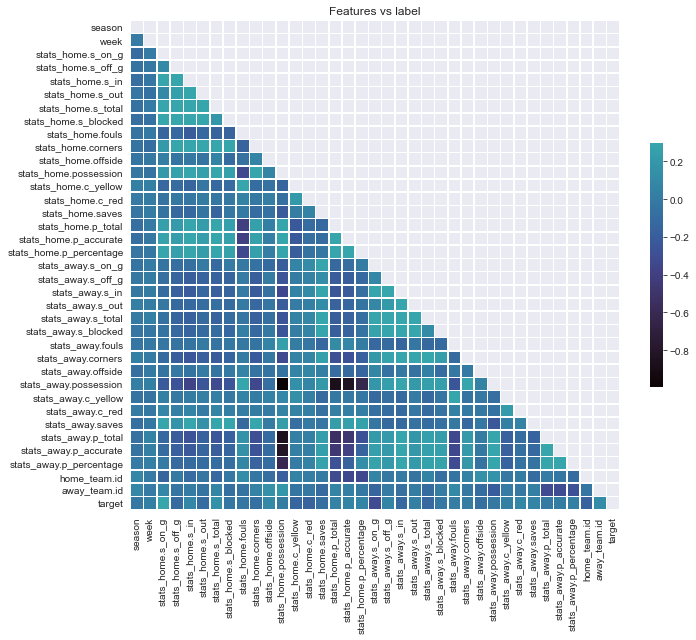

target                 1.000000
stats_home.s_on_g      0.375707
stats_away.s_on_g      0.304274
home_team.id           0.171796
stats_home.s_total     0.156430
stats_home.c_red       0.156317
stats_home.c_yellow    0.147231
stats_away.s_total     0.127224
away_team.id           0.120203
stats_away.s_in        0.115328
stats_home.s_off_g     0.108737
stats_home.offside     0.102309
Name: target, dtype: float64


In [98]:
heatmap_data(all_data, new_target, all_data.columns, 'spearman', 'target')
_, relevant_features = get_correlation(all_data, new_target, all_data.columns, 'spearman', 'target', thresh=0.1)
print(relevant_features)

In [99]:
"""
    Distinguish between a draw or loss
"""

'\n    Distinguish between a draw or loss\n'

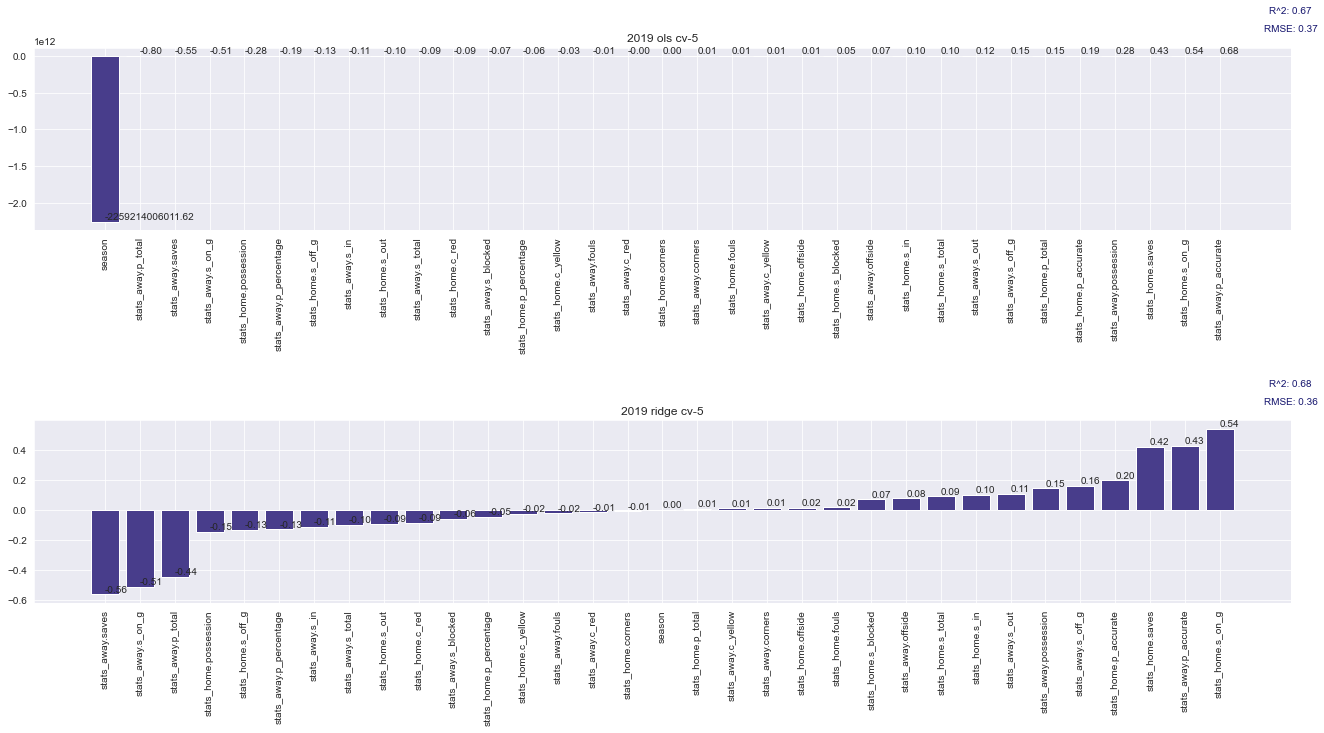

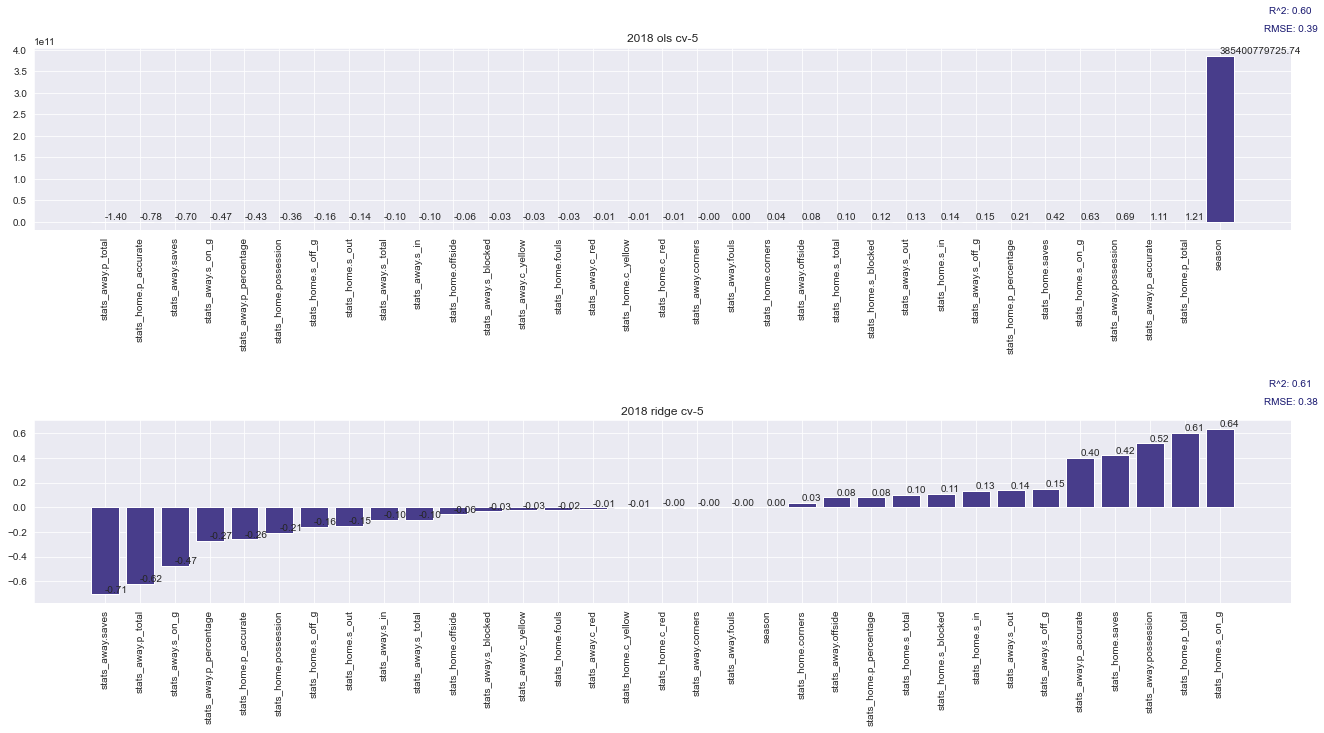

/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in sqrt


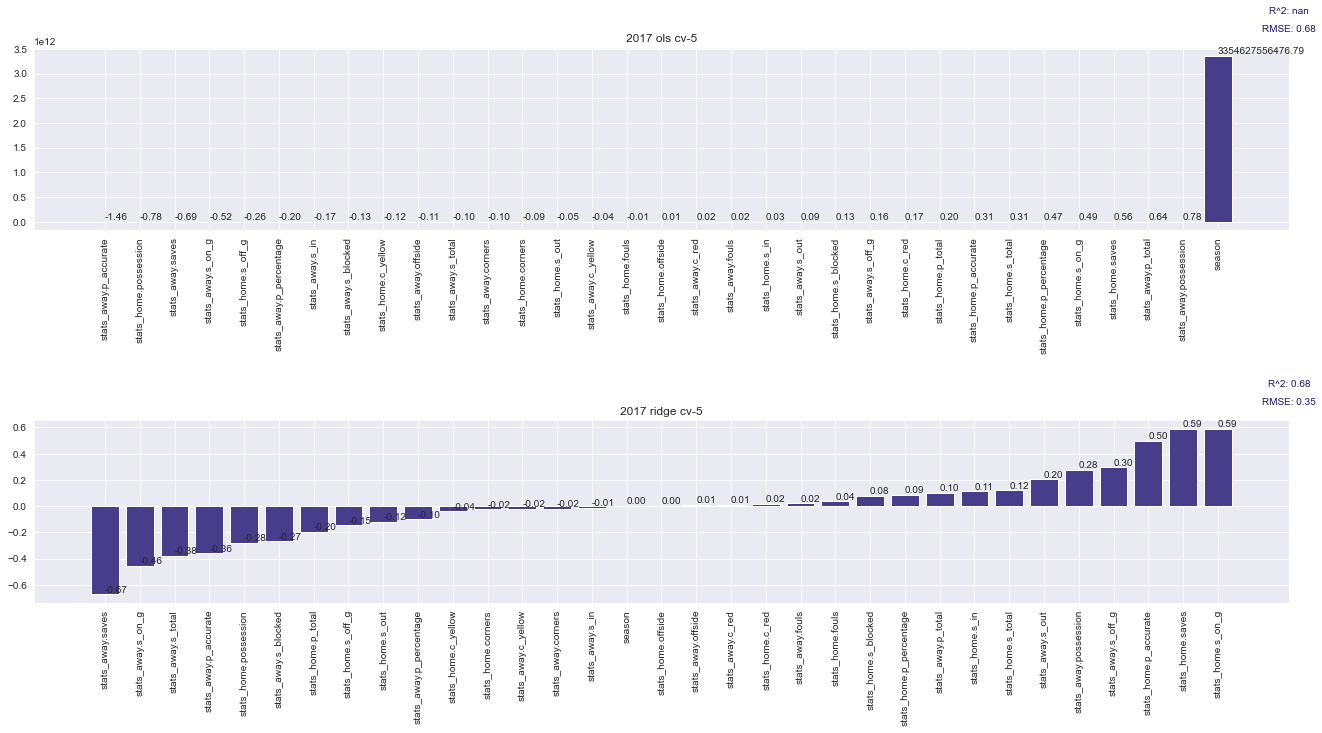

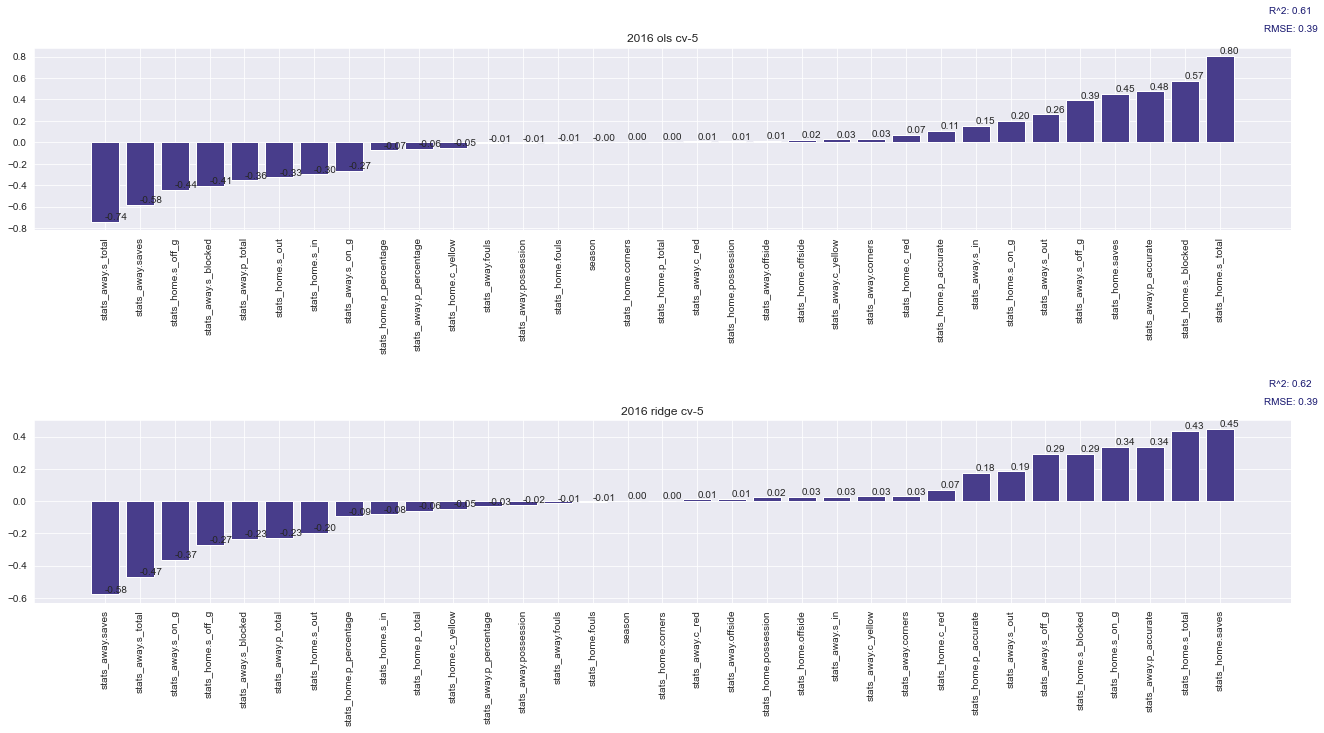

In [100]:
# Labels as 1 for home_win, 0 else
for d in data:
    new_data, new_target = draw_vs_loss(d[1], d[2])
    ols_ridge(d[0], new_data, new_target, cross_val = 5)

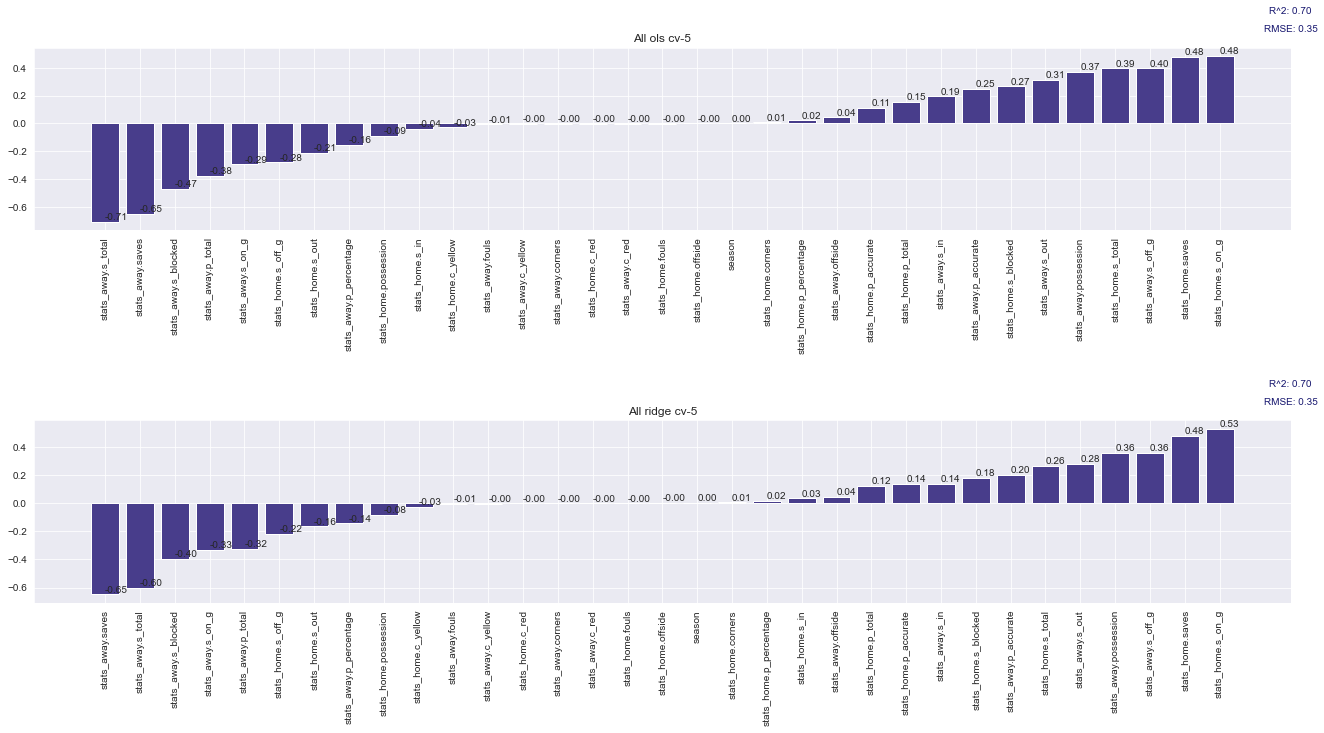

In [101]:
# All data
all_data, all_target = get_all(data)
new_data, new_target = draw_vs_loss(all_data, all_target)
ols_ridge("All", new_data, new_target, cross_val = 5)

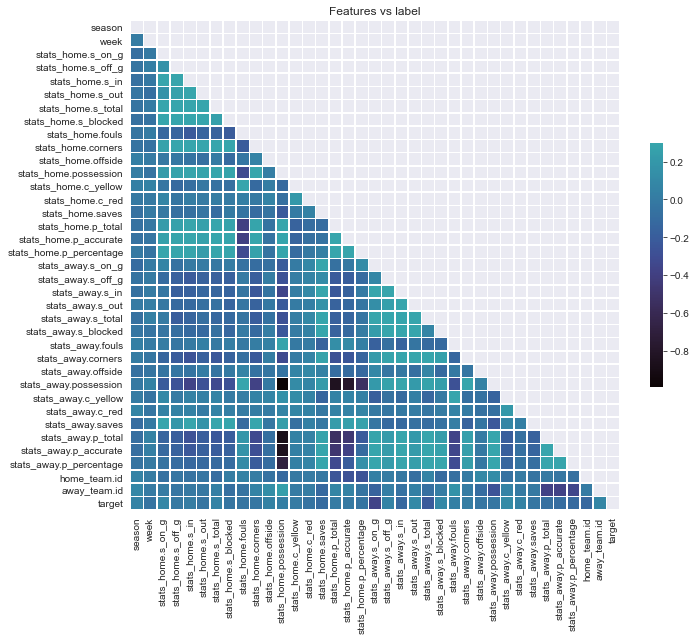

target                     1.000000
stats_away.s_on_g          0.368997
stats_away.s_total         0.215683
home_team.id               0.124931
stats_away.s_in            0.119588
stats_away.p_percentage    0.118082
stats_away.c_yellow        0.111399
stats_home.saves           0.104482
Name: target, dtype: float64


In [102]:
heatmap_data(new_data, new_target, all_data.columns, 'spearman', 'target')
_, relevant_features = get_correlation(new_data, new_target, all_data.columns, 'spearman', 'target', thresh=0.1)
print(relevant_features)

In [ ]:
"""
    Linear regression vs SVM coefficients boundaries
"""
all_data, all_target = get_all(data)
svm_kernel("All SVM ", all_data, all_target)

In [104]:
all_data.head()

,season,week,stats_home.s_on_g,stats_home.s_off_g,stats_home.s_in,stats_home.s_out,stats_home.s_total,stats_home.s_blocked,stats_home.fouls,stats_home.corners,...,stats_away.c_yellow,stats_away.c_red,stats_away.saves,stats_away.p_total,stats_away.p_accurate,stats_away.p_percentage,home_team.id,away_team.id,home_team.name,away_team.name
0,2019,22,4.0,2.0,9,3.0,6.0,3.0,19,4.0,...,2.0,0.0,1.0,384,288,0.750000,533,727,Villarreal,Osasuna
1,2019,10,8.0,5.0,19,6.0,10.0,9.0,12,5.0,...,2.0,0.0,4.0,307,213,0.693811,533,542,Villarreal,Alaves
2,2019,32,4.0,12.0,17,1.0,12.0,5.0,9,1.0,...,2.0,0.0,2.0,484,414,0.855372,533,532,Villarreal,Valencia
3,2019,1,7.0,3.0,12,2.0,7.0,5.0,10,2.0,...,1.0,0.0,3.0,380,311,0.818421,533,715,Villarreal,Granada CF
4,2019,16,3.0,10.0,23,10.0,16.0,7.0,11,11.0,...,1.0,0.0,3.0,462,361,0.781385,533,530,Villarreal,Atletico Madrid


In [105]:
"""Differences model
    1. computes the difference between stats_home - stats_away on this fields:
        s_on_g
        s_total
        s_off_g
        s_in
        s_out
        saves
        p_percentage --> do not affect results
    2. Adds variables as yellow cards individually
    3. Future work: 
        --> when simulation
        pezzali score goals(team)/attempts(team) x attempts(opponent)/goals(opponent)
        Elo ratings
"""

'Differences model\n    1. computes the difference between stats_home - stats_away on this fields:\n        s_on_g\n        s_total\n        s_off_g\n        s_in\n        s_out\n        saves\n        p_percentage --> do not affect results\n    2. Adds variables as yellow cards individually\n    3. Future work: \n        --> when simulation\n        pezzali score goals(team)/attempts(team) x attempts(opponent)/goals(opponent)\n        Elo ratings\n'

In [106]:
def diff_data(data):
    new_data = pd.DataFrame()
    new_data["diff_s_on_g"] = data["stats_home.s_on_g"]-data["stats_away.s_on_g"]
    new_data["diff_s_off_g"] = data["stats_home.s_off_g"]-data["stats_away.s_off_g"]
    new_data["diff_s_total"] = data["stats_home.s_total"]-data["stats_away.s_total"]
    new_data["diff_s_in"] = data["stats_home.s_in"]-data["stats_away.s_in"]
    new_data["diff_s_out"] = data["stats_home.s_out"]-data["stats_away.s_out"]
    new_data["diff_saves"] = data["stats_home.saves"]-data["stats_away.saves"]
    #new_data["diff_p_percentage"] = data["stats_home.p_percentage"]-data["stats_away.p_percentage"]
    new_data["stats_away.c_yellow"] = data["stats_away.c_yellow"]
    new_data["stats_home.c_yellow"] = data["stats_home.c_yellow"]
    return new_data

Other type
Confusion Matrix:
 [[411  16   1]
 [ 30 315  45]
 [  3  37 662]]
Classification Report:
               precision    recall  f1-score   support

          -1       0.93      0.96      0.94       428
           0       0.86      0.81      0.83       390
           1       0.94      0.94      0.94       702

    accuracy                           0.91      1520
   macro avg       0.91      0.90      0.90      1520
weighted avg       0.91      0.91      0.91      1520



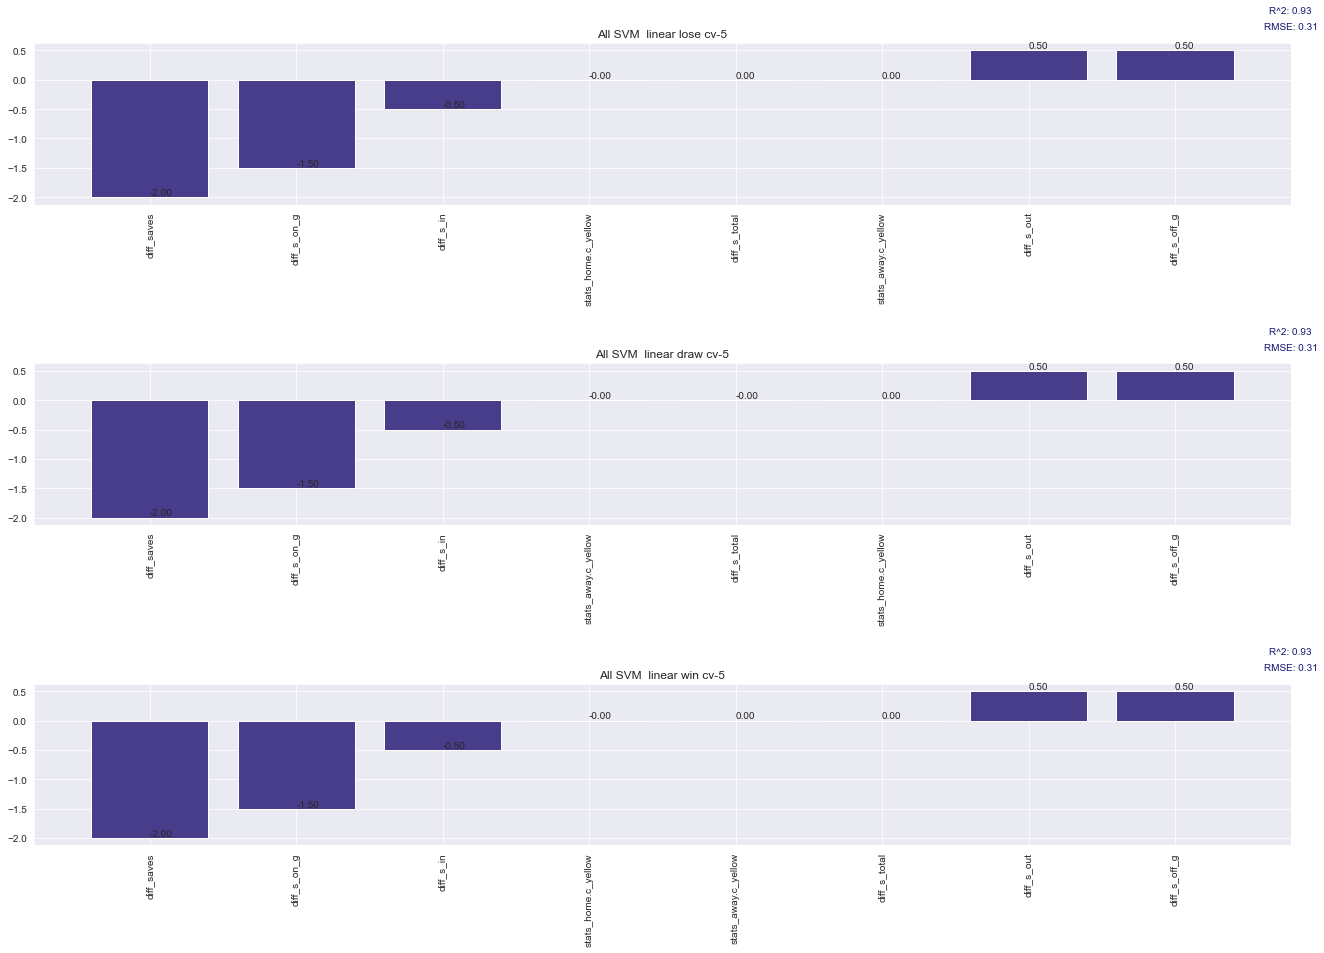

In [107]:
all_data, all_target = get_all(data)
new_data = diff_data(all_data)
svm_kernel("All SVM ", new_data, all_target)

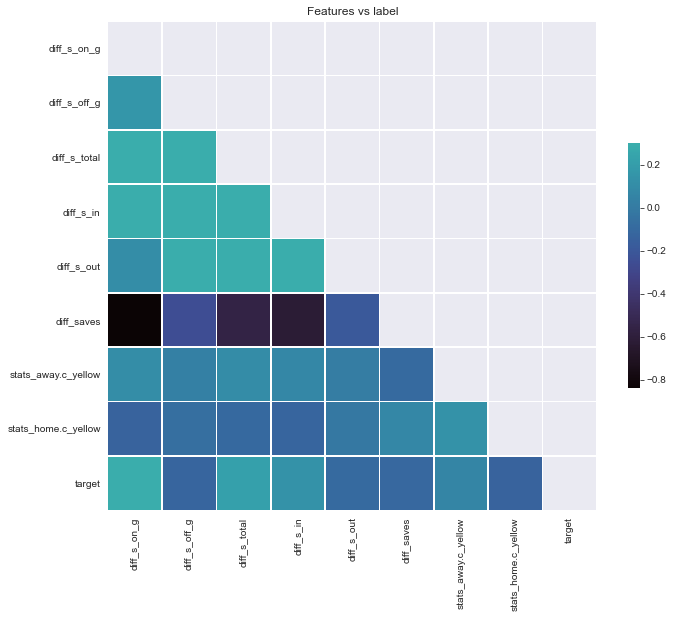

target                 1.000000
diff_s_on_g            0.529088
diff_s_total           0.215721
diff_s_in              0.141867
stats_home.c_yellow    0.136101
diff_s_off_g           0.123790
diff_saves             0.108177
Name: target, dtype: float64


In [108]:
heatmap_data(new_data, all_target, new_data.columns, 'spearman', 'target')
_, relevant_features = get_correlation(new_data, all_target, new_data.columns, 'spearman', 'target', thresh=0.1)
print(relevant_features)

In [109]:
#pezzali score goals(team)/attempts(team) x attempts(opponent)/goals(opponent)
def pezzali_data(data):
    new_data = pd.DataFrame()
    values = {'goal_home': 0, 'goals_away': 0}
    data.fillna(value=values)
    data.reset_index(inplace=True)
    pezzali_diff = []
    shots_fraction = []
    for index, row in data.iterrows():
        att_home = row["stats_home.s_off_g"] + row["stats_home.s_on_g"] + 1
        h_home = (row["goals_home"] + 1)/att_home
        att_away = row["stats_away.s_off_g"] + row["stats_away.s_on_g"] + 1
        h_away = att_away/(row["goals_away"] + 1)
        p_home = h_home * h_away
        a_away = (row["goals_away"] + 1)/att_away
        a_home = att_home/(row["goals_home"] + 1)
        p_away = a_away * a_home
        diff_p = p_home - p_away
        sf_home = row["stats_home.s_in"]+1/(row["stats_home.s_in"]+row["stats_home.s_out"]+1)
        sf_away = row["stats_away.s_in"]+1/(row["stats_home.s_in"]+row["stats_away.s_out"]+1)
        diff_sf = sf_home - sf_away
        pezzali_diff.append(diff_p)
        shots_fraction.append(diff_sf)
    new_data["season"] = data["season"]
    new_data["week"] = data["week"]
    new_data["home_team.id"] = data["home_team.id"]
    new_data["away_team.id"] = data["away_team.id"]
    new_data["home_team.name"] = data["home_team.name"]
    new_data["away_team.name"] = data["away_team.name"]
    new_data["diff_pezzali"] = pezzali_diff
    #new_data["diff_s_on_g"] = data["stats_home.s_on_g"]-data["stats_away.s_on_g"]
    #new_data["diff_s_off_g"] = data["stats_home.s_off_g"]-data["stats_away.s_off_g"]
    #new_data["diff_s_total"] = data["stats_home.s_total"]-data["stats_away.s_total"]
    new_data["diff_s_fraction"] = shots_fraction
    #new_data["diff_s_out"] = data["stats_home.s_out"]-data["stats_away.s_out"]
    new_data["diff_defensive"] = (data["stats_home.saves"]+data["stats_away.s_blocked"])-(data["stats_away.saves"]+data["stats_home.s_blocked"])
    #new_data["diff_p_percentage"] = data["stats_home.p_percentage"]-data["stats_away.p_percentage"]
    new_data["stats_away.c_yellow"] = data["stats_away.c_yellow"]
    new_data["stats_home.c_yellow"] = data["stats_home.c_yellow"]
    return new_data

In [110]:
def diff_pezzali(diff, pezzali):
    diff["diff_pezzali"] = pezzali["diff_pezzali"]
    diff["diff_s_fraction"] = pezzali["diff_s_fraction"]
    diff["diff_defensive"] = pezzali["diff_defensive"]
    return diff

In [111]:
# Data initialization
data = []
for season in seasons:
    df, target = df_season(country, league, season, curr_week, drop_goals=False)
    tup = (season, df, target)
    data.append(tup)
all_data, all_target = get_all(data)

In [112]:
pezzali = pezzali_data(all_data)
#svm_kernel("All SVM ", pezzali, all_target)

In [113]:
pezzali.head(5)

,season,week,home_team.id,away_team.id,home_team.name,away_team.name,diff_pezzali,diff_s_fraction,diff_defensive,stats_away.c_yellow,stats_home.c_yellow
0,2019,22,533,727,Villarreal,Osasuna,4.651261,-8.013986,8.0,2.0,3.0
1,2019,10,533,542,Villarreal,Alaves,1.455195,6.993007,-7.0,2.0,2.0
2,2019,32,533,532,Villarreal,Valencia,-1.359477,13.002632,-4.0,2.0,0.0
3,2019,1,533,715,Villarreal,Granada CF,0.174242,-1.995833,-1.0,1.0,3.0
4,2019,16,533,530,Villarreal,Atletico Madrid,-0.148352,4.996078,-1.0,1.0,2.0


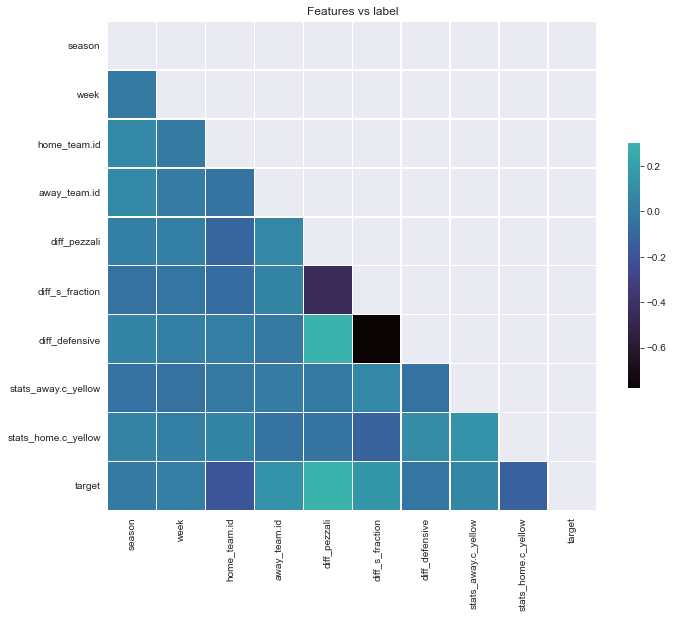

target                 1.000000
diff_pezzali           0.669272
home_team.id           0.192786
diff_s_fraction        0.151960
stats_home.c_yellow    0.136101
away_team.id           0.134088
Name: target, dtype: float64


In [114]:
heatmap_data(pezzali, all_target, pezzali.columns, 'spearman', 'target')
_, relevant_features = get_correlation(pezzali, all_target, pezzali.columns, 'spearman', 'target', thresh=0.1)
print(relevant_features)

In [115]:
d_p = diff_pezzali(new_data, pezzali)
d_p = d_p.drop(columns=["target"])

Other type
Confusion Matrix:
 [[411  16   1]
 [ 30 315  45]
 [  3  37 662]]
Classification Report:
               precision    recall  f1-score   support

          -1       0.93      0.96      0.94       428
           0       0.86      0.81      0.83       390
           1       0.94      0.94      0.94       702

    accuracy                           0.91      1520
   macro avg       0.91      0.90      0.90      1520
weighted avg       0.91      0.91      0.91      1520



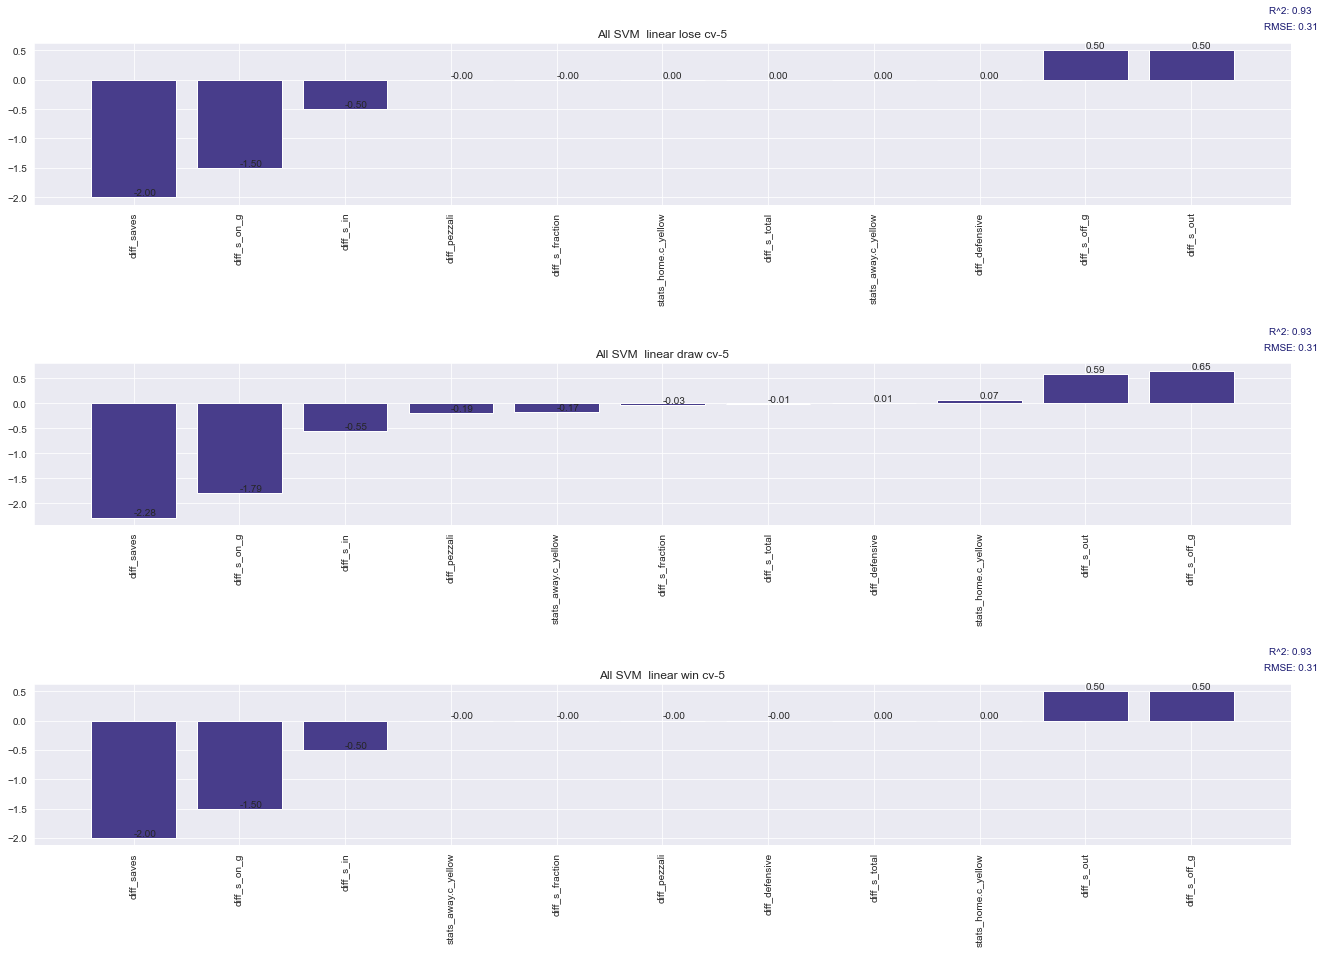

In [116]:
svm_kernel("All SVM ", d_p, all_target)

In [117]:
def every_data(data, pezzali):
    data["diff_s_on_g"] = data["stats_home.s_on_g"]-data["stats_away.s_on_g"]
    data["diff_s_off_g"] = data["stats_home.s_off_g"]-data["stats_away.s_off_g"]
    data["diff_s_total"] = data["stats_home.s_total"]-data["stats_away.s_total"]
    data["diff_s_in"] = data["stats_home.s_in"]-data["stats_away.s_in"]
    data["diff_s_out"] = data["stats_home.s_out"]-data["stats_away.s_out"]
    data["diff_saves"] = data["stats_home.saves"]-data["stats_away.saves"]
    data["diff_p_total"] = data["stats_home.p_total"]-data["stats_away.p_total"]
    data["diff_p_percentage"] = data["stats_home.p_percentage"]-data["stats_away.p_percentage"]
    data["diff_possession"] = data["stats_home.possession"]-data["stats_away.possession"]
    data["diff_pezzali"] = pezzali["diff_pezzali"]
    data["diff_s_fraction"] = pezzali["diff_s_fraction"]
    data["diff_defensive"] = pezzali["diff_defensive"]
    return data

In [174]:
import statsmodels.api as sm

def ols_with_stats(data, target):
    try:
        data = data.drop(columns=['week','home_team.id', 'away_team.id','home_team.name', 'away_team.name'])
    except:
        print('No')
    try:
        data = data.drop(columns=['target'])
    except:
        print('No target field')
    
    X = data.astype(float)
    Y = target

    #X = sm.add_constant(X) # adding a constant

    model = sm.OLS(Y, X).fit()
    predictions = model.predict(X) 
    print_model = model.summary()
    print(print_model)

In [206]:
# All data
all_data, all_target = get_all(data)
test_data = every_data(all_data, pezzali)
ols_with_stats(test_data, diff_target)

No target field
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.945
Model:                            OLS   Adj. R-squared (uncentered):              0.943
Method:                 Least Squares   F-statistic:                              746.2
Date:                Wed, 14 Oct 2020   Prob (F-statistic):                        0.00
Time:                        21:31:01   Log-Likelihood:                         -841.82
No. Observations:                1520   AIC:                                      1752.
Df Residuals:                    1486   BIC:                                      1933.
Df Model:                          34                                                  
Covariance Type:            nonrobust                                                  
                              coef    std err          t      P>|t|      [0.025      0.975]
------------

In [207]:
ols_with_stats(test_data, all_target)

No target field
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.724
Model:                            OLS   Adj. R-squared (uncentered):              0.718
Method:                 Least Squares   F-statistic:                              114.7
Date:                Wed, 14 Oct 2020   Prob (F-statistic):                        0.00
Time:                        21:31:05   Log-Likelihood:                         -952.88
No. Observations:                1520   AIC:                                      1974.
Df Residuals:                    1486   BIC:                                      2155.
Df Model:                          34                                                  
Covariance Type:            nonrobust                                                  
                              coef    std err          t      P>|t|      [0.025      0.975]
------------

In [213]:
# Regression with classification
def ultimate_data_two(data, pezzali):
    new_data = pd.DataFrame()
    new_data["stats_home.c_red"] = data["stats_home.c_red"]
    new_data["diff_s_off_g"] = data["stats_home.s_off_g"]-data["stats_away.s_off_g"]
    new_data["diff_s_total"] = data["stats_home.s_total"]-data["stats_away.s_total"]
    new_data["diff_s_out"] = data["stats_home.s_out"]-data["stats_away.s_out"]
    new_data["diff_saves"] = data["stats_home.saves"]-data["stats_away.saves"]
    new_data["stats_home.s_blocked"] = data["stats_home.s_blocked"]
    new_data["stats_away.s_blocked"] = data["stats_away.s_blocked"]
    new_data["diff_pezzali"] = pezzali["diff_pezzali"]
    new_data["diff_s_fraction"] = pezzali["diff_s_fraction"]
    return new_data

In [214]:
# All data
all_data, all_target = get_all(data)
test_data = ultimate_data_two(all_data, pezzali)
ols_with_stats(test_data, all_target)

No
No target field
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.712
Model:                            OLS   Adj. R-squared (uncentered):              0.710
Method:                 Least Squares   F-statistic:                              414.1
Date:                Wed, 14 Oct 2020   Prob (F-statistic):                        0.00
Time:                        21:36:17   Log-Likelihood:                         -986.63
No. Observations:                1520   AIC:                                      1991.
Df Residuals:                    1511   BIC:                                      2039.
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
------------

Other type
Confusion Matrix:
 [[413  14   1]
 [ 29 317  44]
 [  2  32 668]]
Classification Report:
               precision    recall  f1-score   support

          -1       0.93      0.96      0.95       428
           0       0.87      0.81      0.84       390
           1       0.94      0.95      0.94       702

    accuracy                           0.92      1520
   macro avg       0.91      0.91      0.91      1520
weighted avg       0.92      0.92      0.92      1520



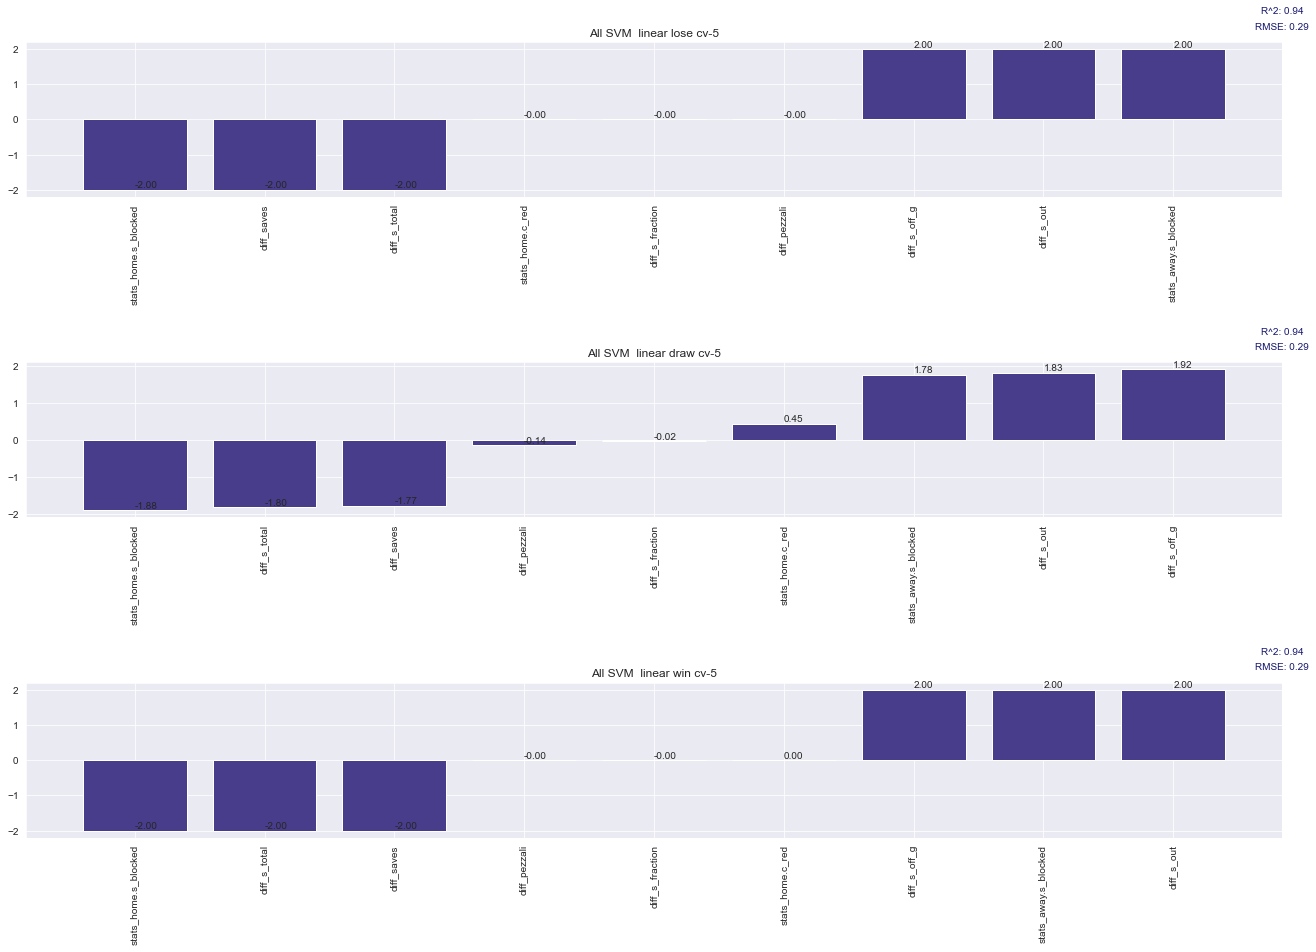

In [215]:
svm_kernel("All SVM ", test_data, all_target)

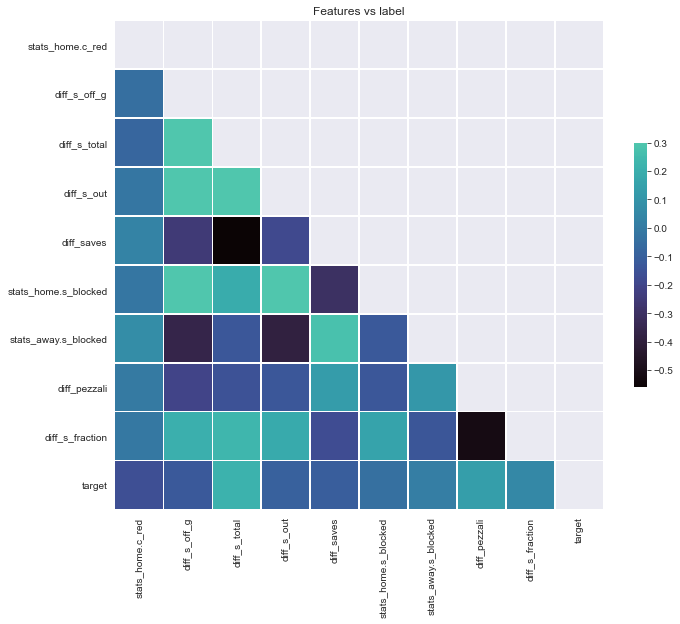

target              1.000000
diff_s_total        0.215721
stats_home.c_red    0.161119
diff_pezzali        0.136064
diff_s_off_g        0.123790
diff_saves          0.108177
Name: target, dtype: float64


In [216]:
heatmap_data(test_data, all_target, test_data.columns, 'spearman', 'target')
_, relevant_features = get_correlation(test_data, all_target, test_data.columns, 'spearman', 'target', thresh=0.1)
print(relevant_features)

In [226]:
# Regression with goals difference
def ultimate_data(data, pezzali):
    new_data = pd.DataFrame()
    new_data["diff_s_on_g"] = data["stats_home.s_on_g"]-data["stats_away.s_on_g"]
    new_data["diff_s_off_g"] = data["stats_home.s_off_g"]-data["stats_away.s_off_g"]
    new_data["diff_s_out"] = data["stats_home.s_out"]-data["stats_away.s_out"]
    new_data["diff_s_in"] = data["stats_home.s_in"]-data["stats_away.s_in"]
    new_data["diff_saves"] = data["stats_home.saves"]-data["stats_away.saves"]
    return new_data

In [227]:
# All data
all_data, all_target = get_all(data)
test_data = ultimate_data(all_data, pezzali)
ols_with_stats(test_data, diff_target)

No
No target field
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.933
Model:                            OLS   Adj. R-squared (uncentered):              0.932
Method:                 Least Squares   F-statistic:                              5239.
Date:                Wed, 14 Oct 2020   Prob (F-statistic):                        0.00
Time:                        21:47:55   Log-Likelihood:                         -992.46
No. Observations:                1520   AIC:                                      1993.
Df Residuals:                    1516   BIC:                                      2014.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------

Other


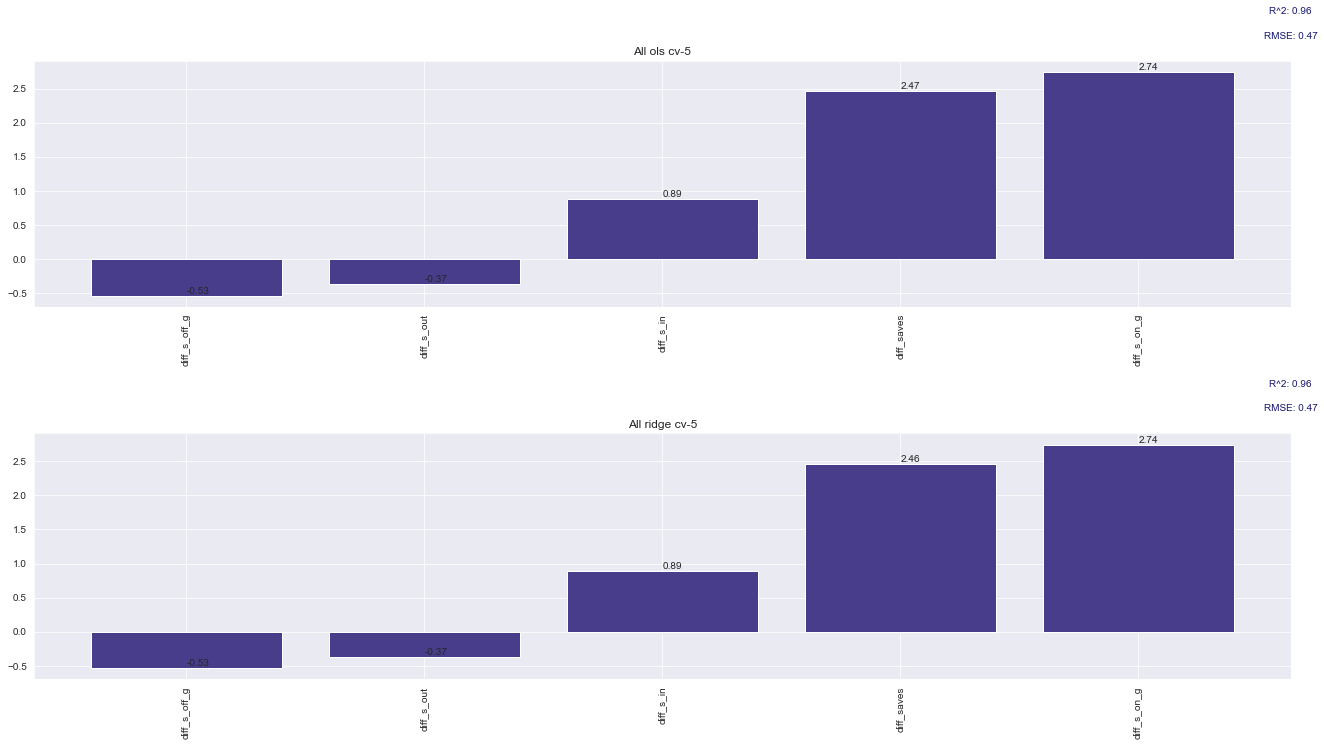

In [229]:
ols_ridge("All", test_data, diff_target, cross_val = 5)

Other type
Confusion Matrix:
 [[411  16   1]
 [ 30 315  45]
 [  3  37 662]]
Classification Report:
               precision    recall  f1-score   support

          -1       0.93      0.96      0.94       428
           0       0.86      0.81      0.83       390
           1       0.94      0.94      0.94       702

    accuracy                           0.91      1520
   macro avg       0.91      0.90      0.90      1520
weighted avg       0.91      0.91      0.91      1520



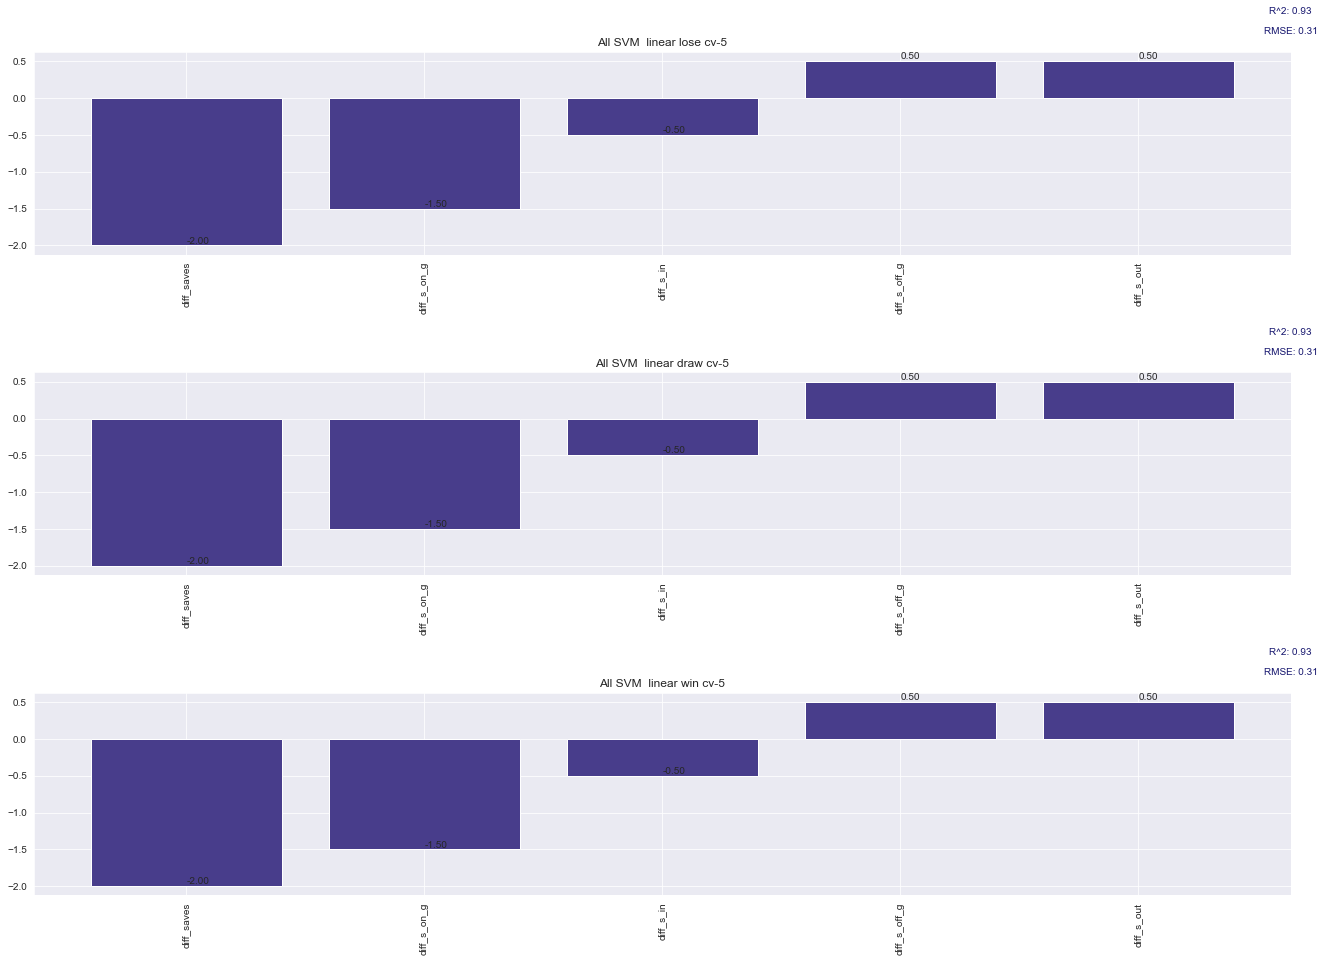

In [230]:
svm_kernel("All SVM ", test_data, all_target)

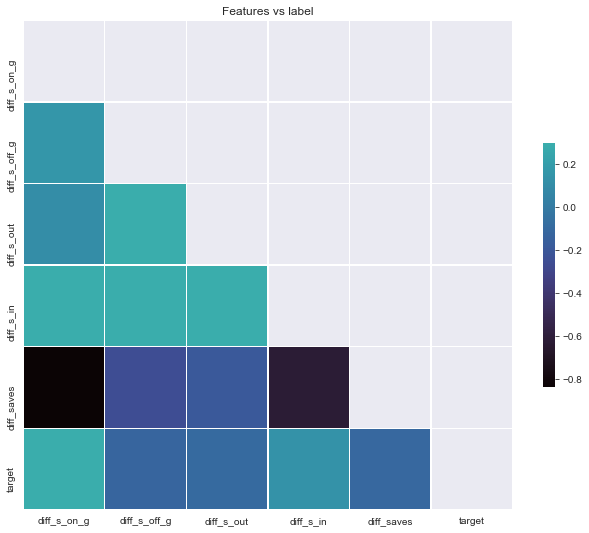

target          1.000000
diff_s_on_g     0.529088
diff_s_in       0.141867
diff_s_off_g    0.123790
diff_saves      0.108177
Name: target, dtype: float64


In [231]:
heatmap_data(test_data, all_target, test_data.columns, 'spearman', 'target')
_, relevant_features = get_correlation(test_data, all_target, test_data.columns, 'spearman', 'target', thresh=0.1)
print(relevant_features)